📂 正在读取文件: ktss.bib
✅ 成功加载 87 条有效文献（摘要长度≥30）


,title,year
0,{Digital government transformation: A case ill...,2018
1,{Big Data-Driven Public Policy Decisions: Tran...,2023
2,{Big Data Analytics: A Catalyst for Digital Tr...,2023
3,{Oecd Countries' Experience in Transformation ...,2024
4,{Building Collaborative Digital Government Sys...,2002



🔧 构建 TF-IDF 向量（含 1-3gram）...
✅ TF-IDF 矩阵维度: (87, 1663)（文档数 × 词特征数）

🧪 Seed-features 命中词表诊断（非常关键）
  - Public service delivery: hits=16 | ['access', 'accessibility', 'citizen', 'citizens', 'delivery', 'experience', 'provision', 'public', 'public service', 'quality', 'satisfaction', 'service']
  - Government organizational structure: hits=12 | ['collaboration', 'coordination', 'governance', 'horizontal', 'integration', 'inter-agency', 'interagency', 'network', 'organization', 'organizational', 'silo', 'structure']
  - Government operating logic and processes: hits=11 | ['automated', 'automation', 'business', 'case', 'operating', 'procedures', 'process', 'processes', 'service', 'standard', 'streamlined']
  - Departmental responsibilities and administrative power: hits=18 | ['accountability', 'administrative', 'bureaucracy', 'bureaucratic', 'control', 'decision', 'decision making', 'departmental', 'discretion', 'functional', 'level', 'making']
  - Leadership: hits=11 | ['capacity', 'commit

E:\Software\Python\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['government'] not in stop_words.
  warnings.warn(


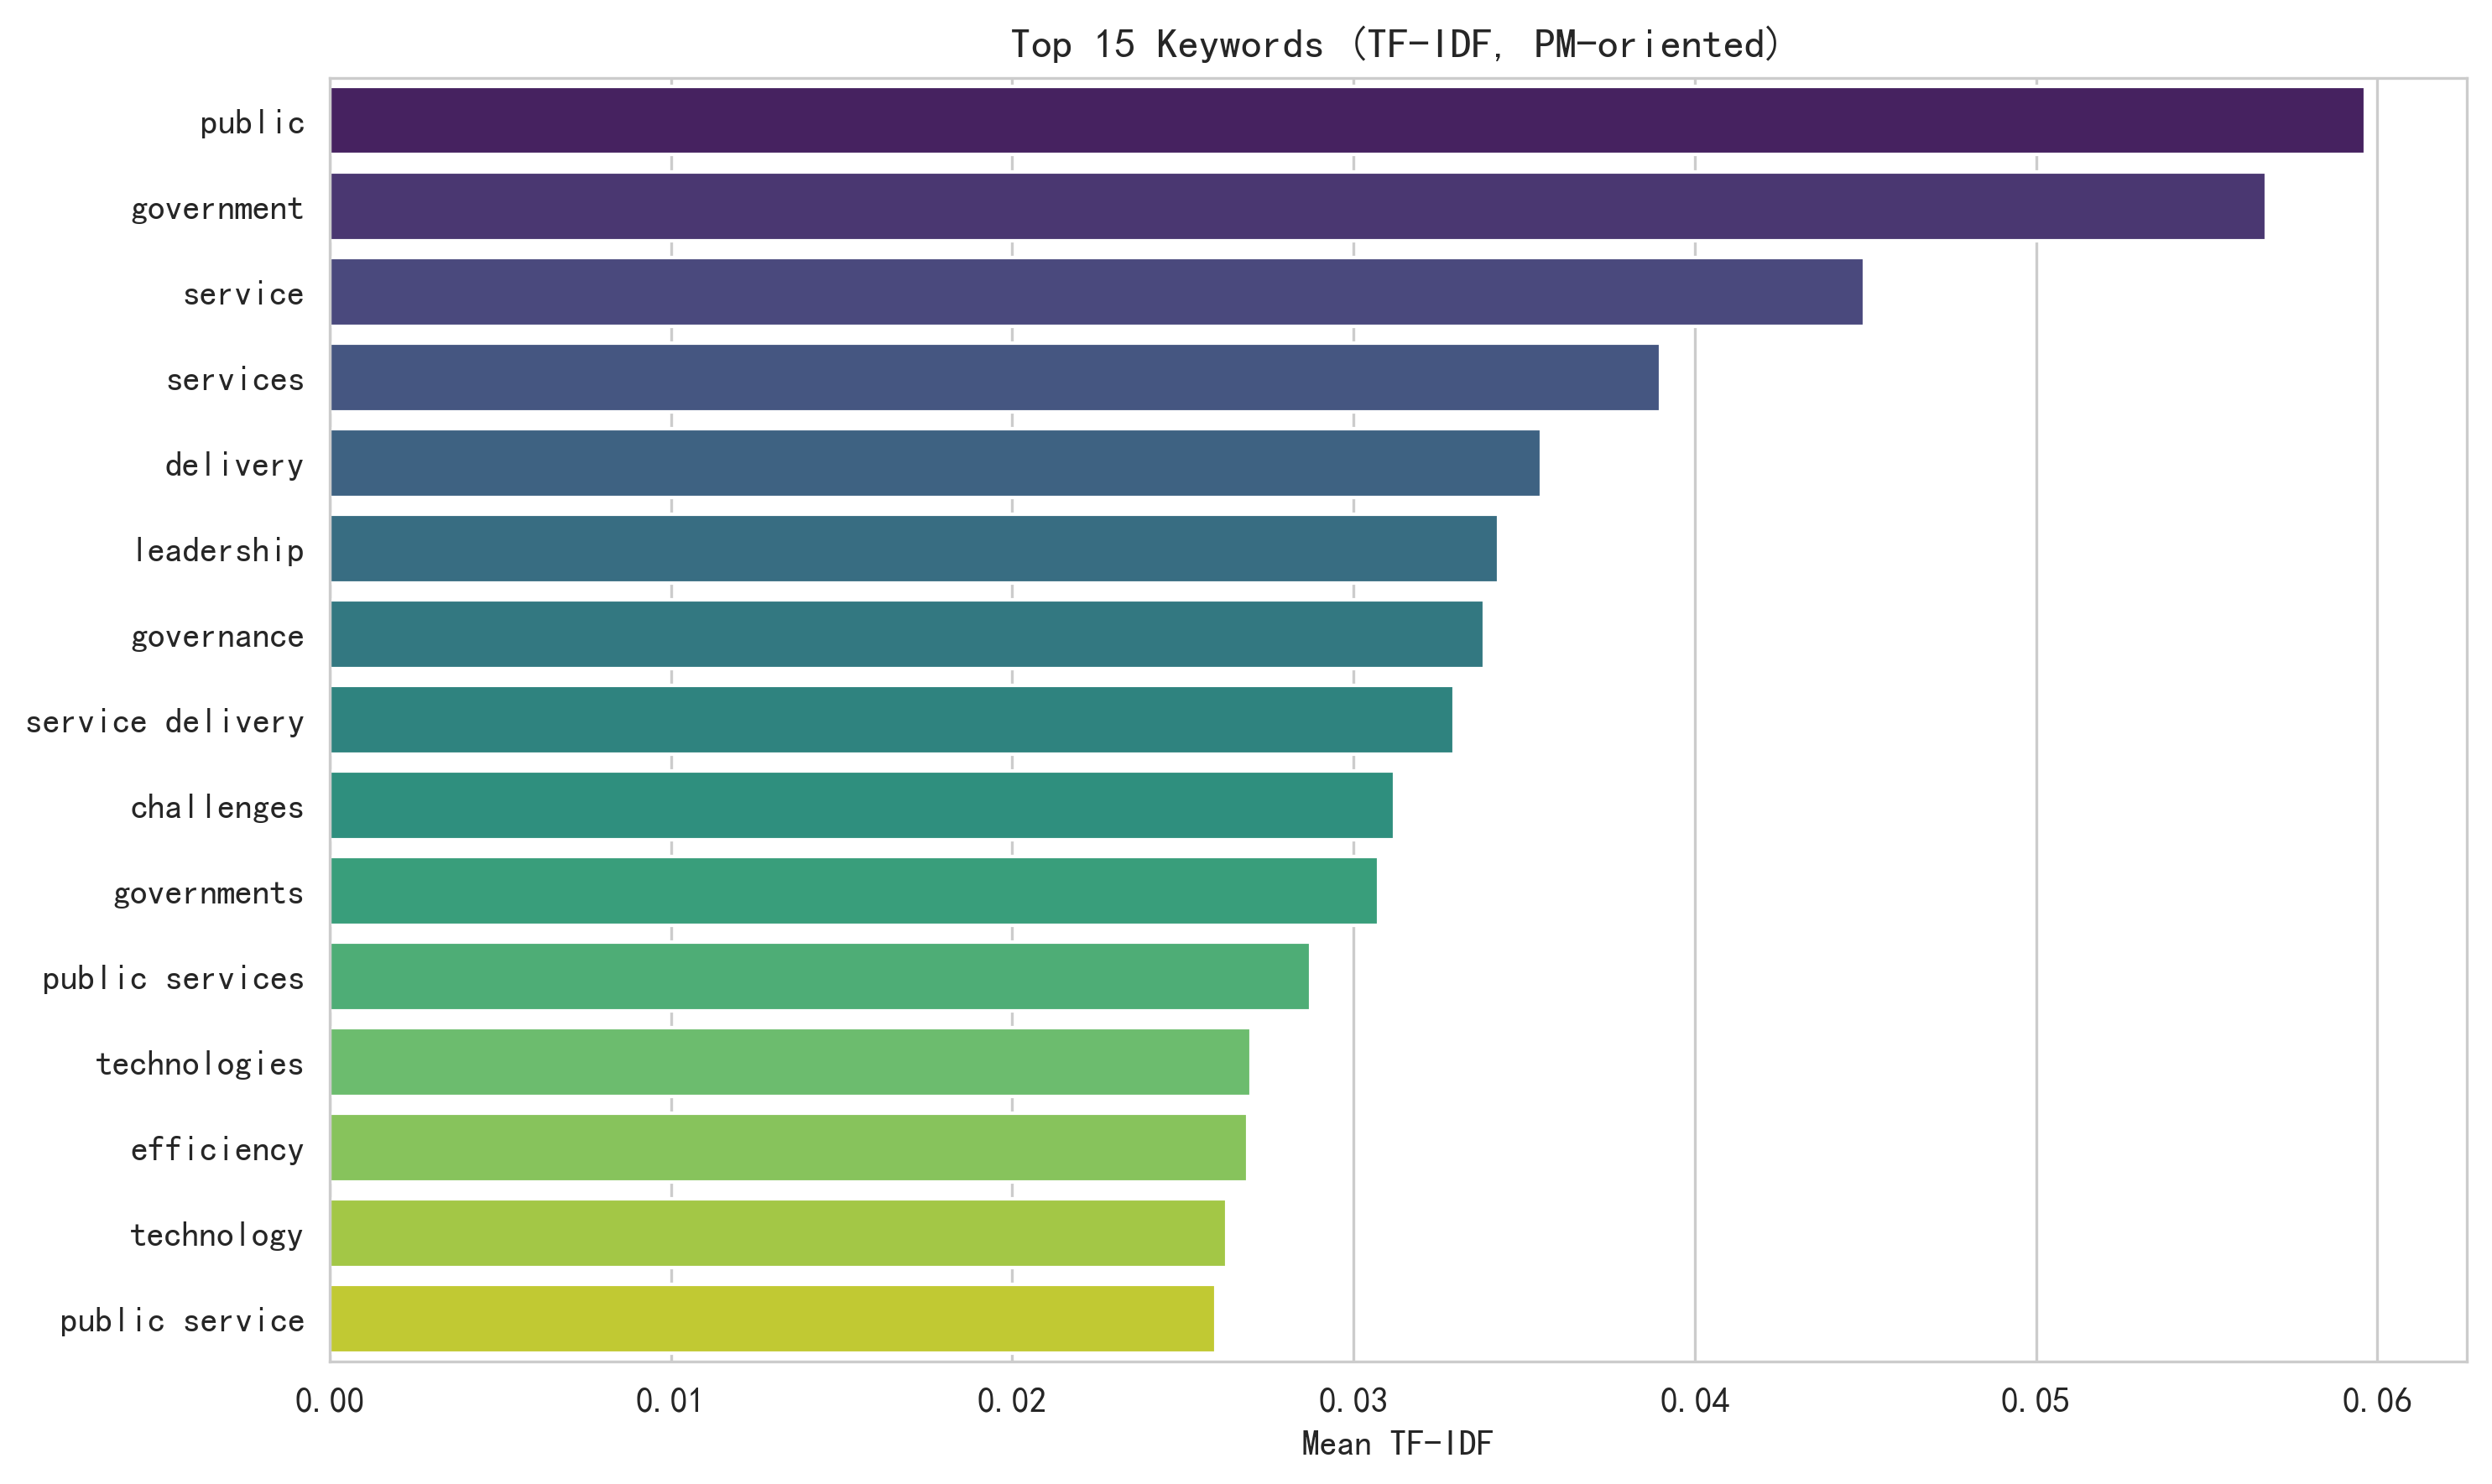


🧠 Seed-guided NMF：提取 12 个主题（per-dim boost）...
✅ Seed boosting done (by seed-features): boosted_cols=68
----------------------------------------------------------------------
Topic 1: service, service delivery, delivery, public service, citizens, public, citizen, accessibility, services, public service delivery, satisfaction, service quality
Topic 2: governance, public, administrative, support, capacity, collaboration, coordination, public governance, inter-agency, access, collaborative, functional
Topic 3: decision, discretion, making, decision making, public, experience, processes, automation, administrative, role, accessibility, solutions
Topic 4: leadership, transformational, transformational leadership, organizational, agility, adaptive, level, influence, vision, role, public, understanding
Topic 5: role, service, role e-governance, including, countries, examines, e-governance, collaboration, inter-agency, leadership, states, play
Topic 6: administrative, organizational, level, co

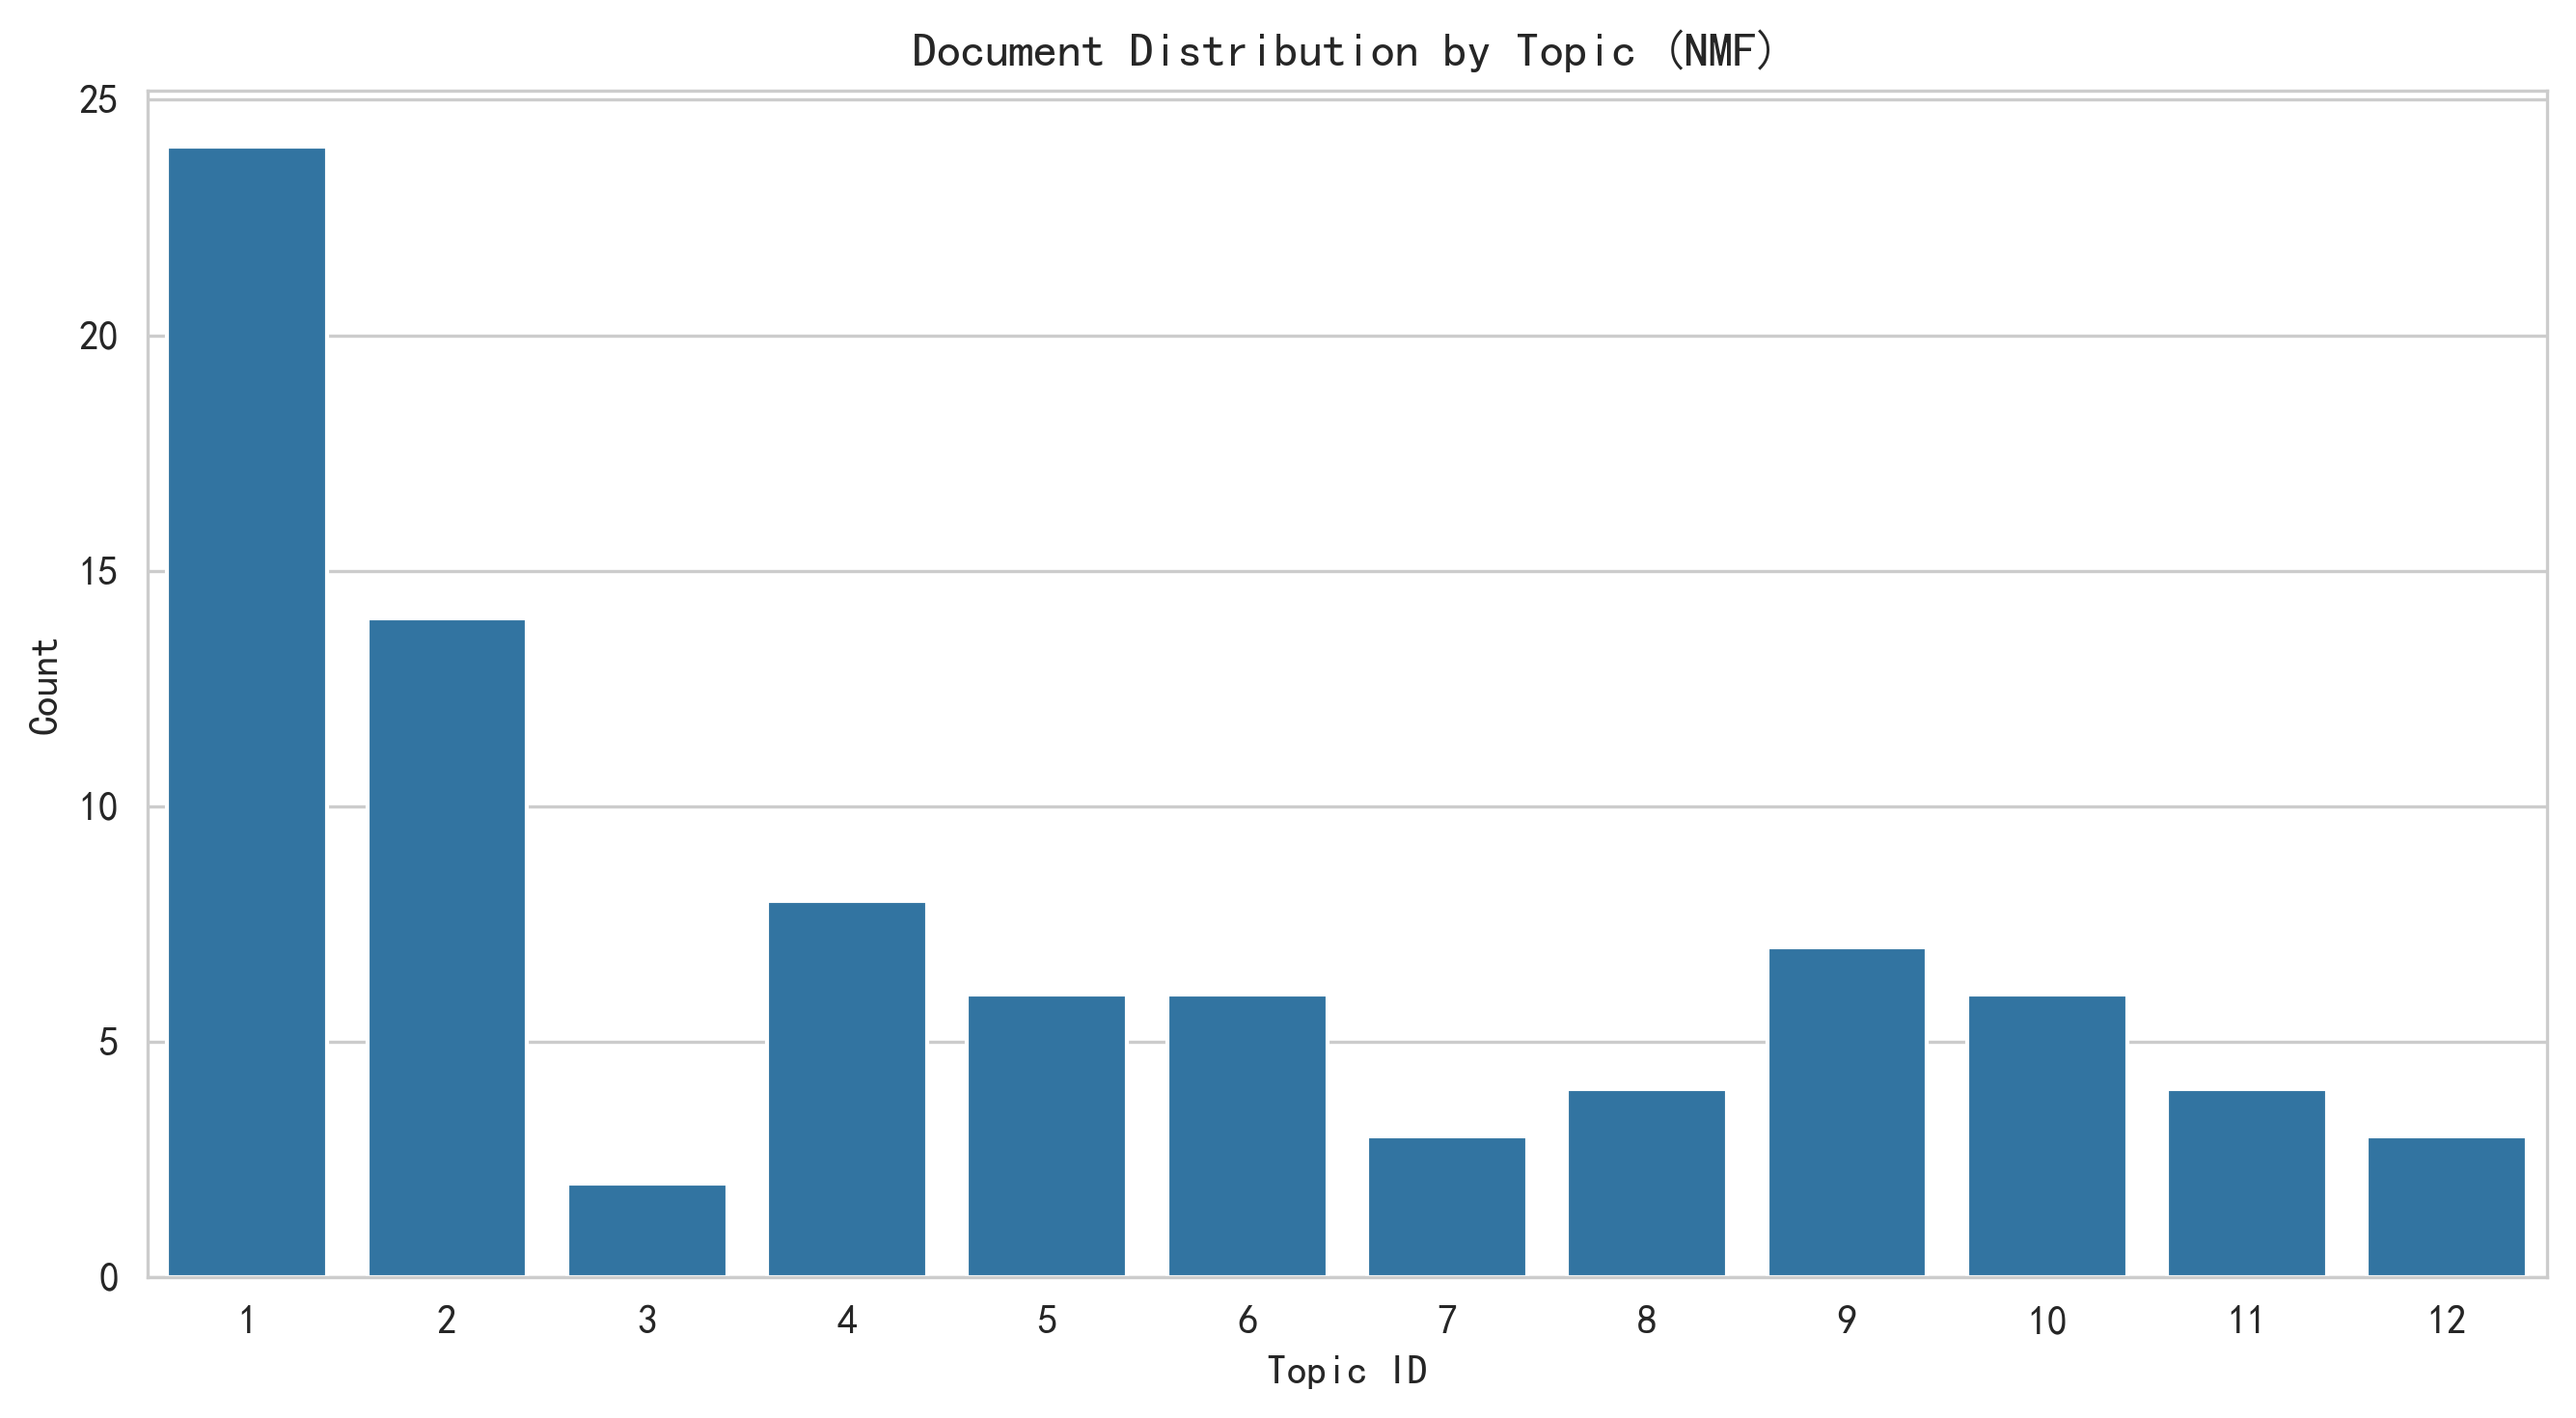


🧩 Topic -> Dimension（many-to-one, ensure_all_dims=True）


,Topic_ID,Mapped_Dimension,Overlap,Top_terms_sample
2,3,Departmental responsibilities and administrati...,6,"decision, discretion, making, decision making,..."
6,7,Departmental responsibilities and administrati...,4,"departmental, standard, rights, business, coll..."
11,12,Departmental responsibilities and administrati...,4,"roles, mechanisms, provision, service provisio..."
8,9,Departmental responsibilities and administrati...,3,"power, process, public, state, pandemic, aspec..."
10,11,Government operating logic and processes,5,"accountability, public, leadership, collaborat..."
1,2,Government organizational structure,6,"governance, public, administrative, support, c..."
5,6,Government organizational structure,6,"administrative, organizational, level, collabo..."
3,4,Leadership,5,"leadership, transformational, transformational..."
7,8,Leadership,4,"bureaucracy, bureaucratic, management, organiz..."
4,5,Leadership,3,"role, service, role e-governance, including, c..."



✅ Dimension counts (show zeros):
Public service delivery                                   30
Government organizational structure                       20
Government operating logic and processes                   4
Departmental responsibilities and administrative power    15
Leadership                                                18
Unmapped                                                   0
Name: Dimension, dtype: Int64

✅ #Topics mapped into each dimension:
Public service delivery                                   2
Government organizational structure                       2
Government operating logic and processes                  1
Departmental responsibilities and administrative power    4
Leadership                                                3
Unmapped                                                  0
dtype: int64


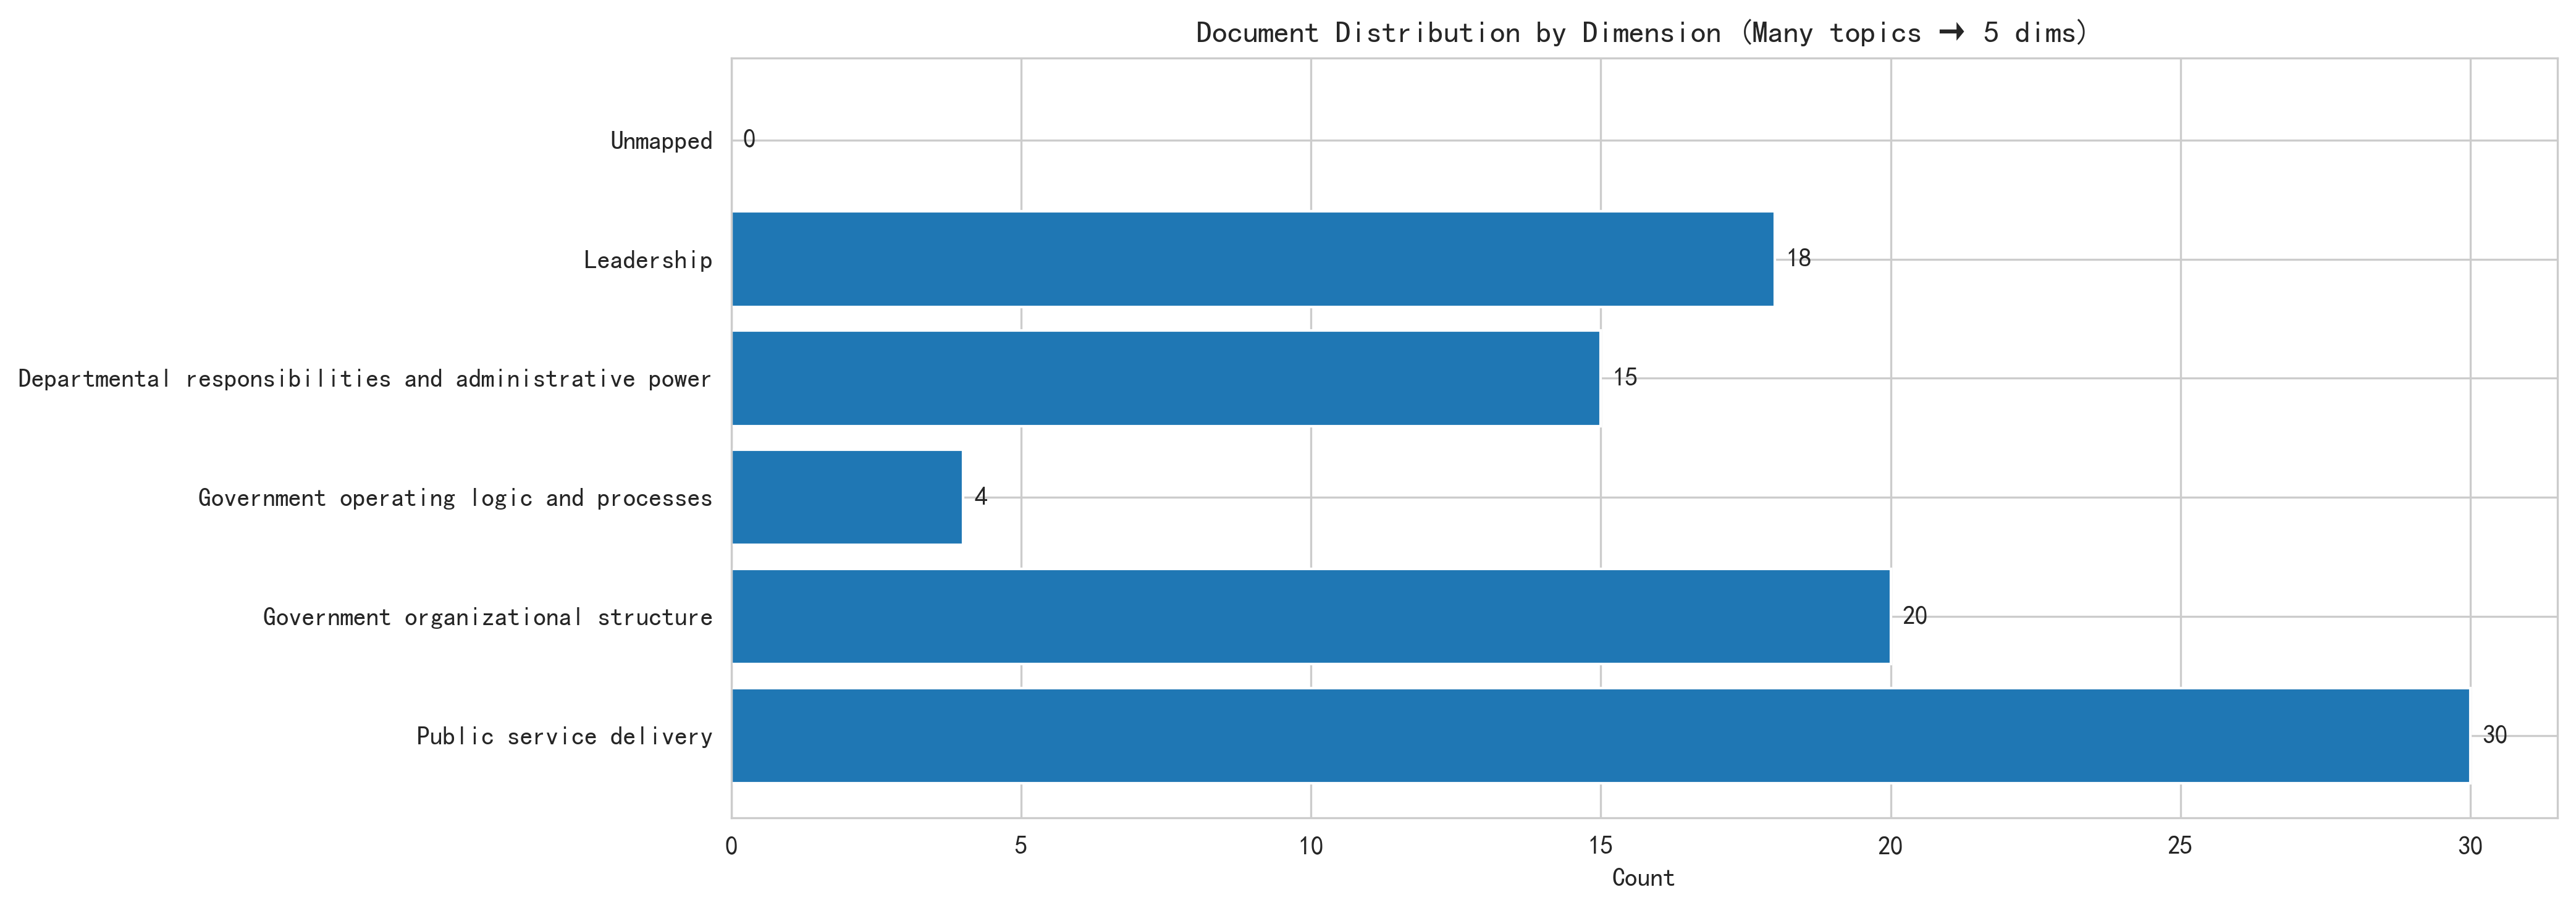


📝 从摘要中抽取关键句（Objective / Method / Result）...
抽样展示:


,title,Objective,Method,Result
0,{Digital government transformation: A case ill...,We investigate how digitalization of public se...,,
1,{Big Data-Driven Public Policy Decisions: Tran...,"Most studies focus on e-government, e-governan...","However, this article aims to explore the pote...","Most studies focus on e-government, e-governan..."
2,{Big Data Analytics: A Catalyst for Digital Tr...,,,The benefits of using BDA in e-Government are ...



💾 已保存: analysis_report.csv


In [ ]:
# ===========================
# Public Management Literature Analyzer (BIB/RIS)
# - TF-IDF (1-3gram) + seed-features (与 vectorizer analyzer 对齐，避免 seed 命中失败)
# - NMF topic modeling (支持 n_topics > 5)
# - Many-to-one: 多个 topic 映射到 5 个维度（可 enforce 覆盖五维）
# - 可选：Seed-score 直接给每篇文献分配 5 维（兜底，不依赖 NMF）
# ===========================

import os
import re
import itertools
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import seaborn as sns

# ========== 可选：导入解析库与 display ==========
try:
    import bibtexparser
    import rispy
    from IPython.display import display
except ImportError:
    print("错误: 缺少必要的库。请运行:")
    print("!pip install bibtexparser rispy pandas scikit-learn matplotlib seaborn")
    def display(x): print(x)

# ========== 绘图风格 ==========
sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# ========== 公共管理向停用词 ==========
# 关键：不要把 public/government/governance 加进停用词，否则 public service 等短语会被拆坏
PM_STOP_WORDS = set(ENGLISH_STOP_WORDS)
PM_STOP_WORDS.update([
    # 学术废词（写作结构词）
    "study","paper","article","research","review","result","results","finding","findings",
    "method","methods","methodology","approach","approaches","model","models","framework",
    "analysis","data","dataset","experiment","experimental","significant","demonstrate",
    "show","shown","present","provide","provides","discuss","discussion","conclusion",
    "based","use","used","using","new","novel","various","different",
    # 技术泛词（高频但区分度低）
    "digital","transformation","e-government","egovernment","digital government",
    "implementation","sector"
])
PM_STOP_WORDS = sorted(PM_STOP_WORDS)

# ========== 5 个维度 seeds ==========
DIM_SEEDS = {
    "Public service delivery": [
        "service delivery","public service","service provision","citizen","citizens",
        "user experience","access","accessibility","convenience","satisfaction",
        "one stop","one-stop","portal","frontline","service quality"
    ],
    "Government organizational structure": [
        "organizational structure","restructuring","organization","hierarchy",
        "coordination","cross department","cross-department","interagency","inter-agency",
        "horizontal","integration","silo","network governance","collaboration"
    ],
    "Government operating logic and processes": [
        # 扩充版：提高在摘要中的可见度，防止被其它维度吸走
        "workflow","workflows","workflow automation","approval workflow",
        "process","processes","service process","business process","business processes",
        "process automation","process standardization","standard operating procedures","sop",
        "procedure","procedures","case processing","case handling","transaction processing",
        "automation","automated workflow","streamlining","streamlined",
        "process reengineering","business process reengineering","bpr",
        "turnaround time","processing time","cycle time"
    ],
    "Departmental responsibilities and administrative power": [
        "administrative power","authority","administrative authority","jurisdiction","delegation",
        "allocation of authority","distribution of power",
        "discretion","administrative discretion","bureaucratic discretion",
        "accountability","accountability mechanisms",
        "roles and responsibilities","role clarity","mandate",
        "decision rights","decision making authority","administrative control","power asymmetry",
        "street level","level bureaucracy","street level bureaucracy",
        # 更常见的摘要表达（建议保留）
        "division of labor","responsibility allocation","allocation of responsibilities",
        "departmental responsibilities","functional responsibilities"
    ],
    "Leadership": [
        "leadership","political support","top management","senior management",
        "strategic vision","commitment","champion","governance capacity",
        "transformational leadership","executive","mayor","party secretary"
    ]
}

def _to_str(x):
    if x is None:
        return ""
    if isinstance(x, list):
        return " ".join([str(i) for i in x if i is not None])
    return str(x)

def _clean_abstract(text: str) -> str:
    if not text:
        return ""
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

class LiteratureAnalyzer:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = []
        self.df = None

        self.vectorizer = None
        self.feature_names = None
        self.tfidf_matrix = None

        self.nmf_model = None
        self.topic_values = None

        # seeds -> seed-features（与 TF-IDF 特征空间一致）
        self.seed_features_by_dim = None

        # topic -> dimension mapping
        self.topic_to_dimension = None

    # --------------------------
    # Load BIB/RIS
    # --------------------------
    def load_data(self, min_abstract_len=30):
        if not self.filepath or not os.path.exists(self.filepath):
            print(f"❌ 错误：找不到文件 '{self.filepath}'")
            return False

        ext = os.path.splitext(self.filepath)[1].lower()
        print(f"📂 正在读取文件: {self.filepath}")

        try:
            if ext == ".ris":
                with open(self.filepath, "r", encoding="utf-8", errors="ignore") as f:
                    entries = rispy.load(f)
                for e in entries:
                    title = _to_str(e.get("primary_title") or e.get("title") or "No Title")
                    abstract = _to_str(e.get("abstract") or e.get("notes") or "")
                    year = _to_str(
                        e.get("year") or e.get("publication_year") or e.get("date") or e.get("publication_date") or ""
                    )
                    self.data.append({
                        "title": title.strip(),
                        "abstract": _clean_abstract(abstract),
                        "year": year.strip()
                    })

            elif ext == ".bib":
                with open(self.filepath, "r", encoding="utf-8", errors="ignore") as f:
                    bib_database = bibtexparser.load(f)
                for e in bib_database.entries:
                    title = _to_str(e.get("title", "No Title"))
                    abstract = _to_str(e.get("abstract", ""))
                    year = _to_str(e.get("year", ""))
                    self.data.append({
                        "title": title.strip(),
                        "abstract": _clean_abstract(abstract),
                        "year": year.strip()
                    })
            else:
                print("❌ 不支持的文件格式。仅支持 .ris 或 .bib")
                return False

            self.df = pd.DataFrame(self.data)
            self.df["abstract"] = self.df["abstract"].fillna("").astype(str)
            self.df = self.df[self.df["abstract"].str.len() >= min_abstract_len].copy()

            print(f"✅ 成功加载 {len(self.df)} 条有效文献（摘要长度≥{min_abstract_len}）")
            display(self.df[["title", "year"]].head(5))
            return True

        except Exception as e:
            print(f"❌ 读取失败: {e}")
            return False

    # --------------------------
    # TF-IDF
    # --------------------------
    def build_tfidf(self, max_features=8000, max_df=0.98, min_df=2, ngram_range=(1, 3)):
        """
        关键点：
        - ngram_range=(1,3)
        - max_df=0.98：避免 process/processes 这类“非常常见但对维度很关键”的词被删掉
        """
        print("\n🔧 构建 TF-IDF 向量（含 1-3gram）...")

        self.vectorizer = TfidfVectorizer(
            stop_words=PM_STOP_WORDS,
            ngram_range=ngram_range,
            max_features=max_features,
            max_df=max_df,
            min_df=min_df,
            sublinear_tf=True,
            token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z0-9\-]+\b"
        )

        self.tfidf_matrix = self.vectorizer.fit_transform(self.df["abstract"])
        self.feature_names = self.vectorizer.get_feature_names_out()
        print(f"✅ TF-IDF 矩阵维度: {self.tfidf_matrix.shape}（文档数 × 词特征数）")

        self._prepare_seed_features()

    def _prepare_seed_features(self):
        """
        将 DIM_SEEDS 短语用 vectorizer.build_analyzer() 转为与 TF-IDF 一致的 tokens/ngrams，
        再与 vocab 相交得到 seed-features。
        """
        analyzer = self.vectorizer.build_analyzer()
        vocab = set(self.feature_names)

        self.seed_features_by_dim = {}
        for dim, seed_phrases in DIM_SEEDS.items():
            feats = set()
            for phrase in seed_phrases:
                for tok in analyzer(phrase):
                    if tok in vocab:
                        feats.add(tok)
            self.seed_features_by_dim[dim] = feats

        print("\n🧪 Seed-features 命中词表诊断（非常关键）")
        for dim in DIM_SEEDS.keys():
            hits = sorted(list(self.seed_features_by_dim[dim]))
            print(f"  - {dim}: hits={len(hits)} | {hits[:12]}")

    # --------------------------
    # Keywords
    # --------------------------
    def analyze_keywords(self, top_n=15, plot=True):
        if self.tfidf_matrix is None:
            print("⚠️ 请先运行 build_tfidf()")
            return []

        print("\n🔍 关键词分析（Top Mean TF-IDF terms）...")
        mean_tfidf = np.asarray(self.tfidf_matrix.mean(axis=0)).ravel()
        top_idx = mean_tfidf.argsort()[-top_n:][::-1]

        keywords = [self.feature_names[i] for i in top_idx]
        scores = [mean_tfidf[i] for i in top_idx]

        if plot:
            plt.figure(figsize=(10, 6), dpi=300)
            sns.barplot(x=scores, y=keywords, hue=keywords, palette="viridis", legend=False)
            plt.title(f"Top {top_n} Keywords (TF-IDF, PM-oriented)")
            plt.xlabel("Mean TF-IDF")
            plt.ylabel("")
            plt.tight_layout()
            plt.show()

        return keywords

    # --------------------------
    # Seed-feature Boosting
    # --------------------------
    def _boost_seed_features(self, boost_dict):
        if self.seed_features_by_dim is None:
            print("⚠️ seed_features_by_dim 为空，请先 build_tfidf()")
            return 0

        term_to_idx = {t: i for i, t in enumerate(self.feature_names)}
        mat = self.tfidf_matrix.tocsc(copy=True)

        hit_total = 0
        for dim, feats in self.seed_features_by_dim.items():
            b = float(boost_dict.get(dim, 1.0))
            if b <= 1.0 or not feats:
                continue
            cols = [term_to_idx[f] for f in feats if f in term_to_idx]
            if not cols:
                continue
            mat[:, cols] = mat[:, cols].multiply(b)
            hit_total += len(cols)

        self.tfidf_matrix = mat.tocsr()
        print(f"✅ Seed boosting done (by seed-features): boosted_cols={hit_total}")
        return hit_total

    # --------------------------
    # NMF Topics
    # --------------------------
    def extract_topics_guided(self, n_topics=12, seed_boost=None, top_terms=12, plot=True):
        if self.tfidf_matrix is None:
            print("⚠️ 请先运行 build_tfidf()")
            return

        if seed_boost is None:
            seed_boost = {d: 2.5 for d in DIM_SEEDS.keys()}

        print(f"\n🧠 Seed-guided NMF：提取 {n_topics} 个主题（per-dim boost）...")
        self._boost_seed_features(seed_boost)

        self.nmf_model = NMF(
            n_components=n_topics,
            random_state=42,
            init="nndsvda",
            max_iter=1500
        )

        self.topic_values = self.nmf_model.fit_transform(self.tfidf_matrix)
        self.df["Topic_ID"] = (self.topic_values.argmax(axis=1) + 1).astype(int)

        print("-" * 70)
        for k, comp in enumerate(self.nmf_model.components_, start=1):
            top_idx = comp.argsort()[::-1][:top_terms]
            words = [self.feature_names[i] for i in top_idx]
            print(f"Topic {k}: {', '.join(words)}")
        print("-" * 70)

        if plot:
            plt.figure(figsize=(9, 5), dpi=300)
            sns.countplot(x="Topic_ID", data=self.df, color=sns.color_palette()[0])
            plt.title("Document Distribution by Topic (NMF)")
            plt.xlabel("Topic ID")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()

        counts = self.df["Topic_ID"].value_counts().reindex(range(1, n_topics + 1), fill_value=0)
        empty_topics = counts[counts == 0].index.tolist()
        if empty_topics:
            print(f"⚠️ 存在空 Topic（无文献归入）：{empty_topics}")

    # --------------------------
    # Many topics -> 5 dimensions (many-to-one, ensure coverage)
    # --------------------------
    def map_topics_to_dimensions_many(self, top_k=35, min_overlap=1, ensure_all_dims=True, plot=True):
        if self.nmf_model is None:
            print("⚠️ 请先运行 extract_topics_guided()")
            return None
        if self.seed_features_by_dim is None:
            print("⚠️ seed_features_by_dim 为空：请先 build_tfidf()")
            return None

        dims = list(DIM_SEEDS.keys())
        dim_seed_sets = {d: set([x.lower() for x in self.seed_features_by_dim.get(d, set())]) for d in dims}

        # topic -> top terms
        topic_top_terms = {}
        for topic_idx, comp in enumerate(self.nmf_model.components_, start=1):
            top_idx = comp.argsort()[::-1][:top_k]
            topic_top_terms[topic_idx] = [self.feature_names[i] for i in top_idx]

        topics = list(topic_top_terms.keys())

        # overlap matrix: topics x dims
        score = np.zeros((len(topics), len(dims)), dtype=int)
        for i, t in enumerate(topics):
            terms_lower = set([x.lower() for x in topic_top_terms[t]])
            for j, d in enumerate(dims):
                score[i, j] = len(terms_lower & dim_seed_sets[d])

        # baseline many-to-one
        base_map = {}
        for i, t in enumerate(topics):
            best_j = int(score[i].argmax())
            best_dim = dims[best_j]
            best_score = int(score[i, best_j])
            base_map[t] = best_dim if best_score >= min_overlap else "Unmapped"

        mapping = dict(base_map)

        # enforce coverage of 5 dims (anchors)
        if ensure_all_dims:
            impossible = [dims[j] for j in range(len(dims)) if score[:, j].max() < min_overlap]
            if impossible:
                print(f"⚠️ 这些维度在所有 topics 上 overlap<{min_overlap}，无法覆盖：{impossible}")
            else:
                pairs = []
                for i, t in enumerate(topics):
                    for j, d in enumerate(dims):
                        pairs.append((int(score[i, j]), t, d))
                pairs.sort(reverse=True, key=lambda x: x[0])

                used_topics, used_dims = set(), set()
                for s, t, d in pairs:
                    if s < min_overlap:
                        break
                    if t in used_topics or d in used_dims:
                        continue
                    mapping[t] = d
                    used_topics.add(t)
                    used_dims.add(d)
                    if len(used_dims) == len(dims):
                        break

        # mapping table
        rows = []
        for i, t in enumerate(topics):
            mapped = mapping[t]
            ov = 0
            if mapped in dims:
                j = dims.index(mapped)
                ov = int(score[i, j])
            rows.append({
                "Topic_ID": t,
                "Mapped_Dimension": mapped,
                "Overlap": ov,
                "Top_terms_sample": ", ".join(topic_top_terms[t][:12])
            })

        map_df = pd.DataFrame(rows).sort_values(["Mapped_Dimension", "Overlap"], ascending=[True, False])
        print(f"\n🧩 Topic -> Dimension（many-to-one, ensure_all_dims={ensure_all_dims}）")
        display(map_df)

        # write back to docs
        self.df["Topic_ID"] = self.df["Topic_ID"].astype(int)
        self.df["Dimension"] = self.df["Topic_ID"].map(mapping).astype("string").str.strip()

        show_dims = dims + ["Unmapped"]
        counts = self.df["Dimension"].value_counts(dropna=False).reindex(show_dims, fill_value=0)
        print("\n✅ Dimension counts (show zeros):")
        print(counts)

        topic_dim_counts = pd.Series(mapping).value_counts().reindex(show_dims, fill_value=0)
        print("\n✅ #Topics mapped into each dimension:")
        print(topic_dim_counts)

        if plot:
            plt.figure(figsize=(14, 5), dpi=300)
            plt.barh(counts.index, counts.values)
            plt.title("Document Distribution by Dimension (Many topics → 5 dims)")
            plt.xlabel("Count")
            plt.gcf().subplots_adjust(left=0.42)
            for ii, v in enumerate(counts.values):
                plt.text(v + 0.2, ii, str(v), va="center")
            plt.tight_layout()
            plt.show()

        self.topic_to_dimension = mapping
        return mapping, map_df

    # --------------------------
    # Optional: Document-level Dimension by seed-score (robust fallback)
    # --------------------------
    def assign_dimensions_by_seed_score(self, force_nonzero=True, plot=True):
        if self.seed_features_by_dim is None:
            print("⚠️ seed_features_by_dim 为空，请先 build_tfidf()")
            return None

        dims = list(DIM_SEEDS.keys())
        term_to_idx = {t: i for i, t in enumerate(self.feature_names)}
        X = self.tfidf_matrix.tocsr()

        dim_cols = {}
        for d in dims:
            feats = self.seed_features_by_dim.get(d, set())
            cols = [term_to_idx[f] for f in feats if f in term_to_idx]
            dim_cols[d] = cols

        scores = np.zeros((X.shape[0], len(dims)), dtype=float)
        for j, d in enumerate(dims):
            cols = dim_cols[d]
            if cols:
                scores[:, j] = np.asarray(X[:, cols].sum(axis=1)).ravel()

        best = scores.argmax(axis=1)
        self.df["Dimension_seedscore"] = [dims[j] for j in best]

        if force_nonzero:
            vc = self.df["Dimension_seedscore"].value_counts().reindex(dims, fill_value=0)
            missing = [d for d in dims if vc[d] == 0 and len(dim_cols[d]) > 0]
            for d in missing:
                j = dims.index(d)
                idx = int(scores[:, j].argmax())
                if scores[idx, j] > 0:
                    self.df.loc[self.df.index[idx], "Dimension_seedscore"] = d

        counts = self.df["Dimension_seedscore"].value_counts().reindex(dims, fill_value=0)
        print("\n✅ Dimension_seedscore counts (show zeros):")
        print(counts)

        if plot:
            plt.figure(figsize=(14, 5), dpi=300)
            plt.barh(counts.index, counts.values)
            plt.title("Document Distribution by Dimension (Seed-score, show zeros)")
            plt.xlabel("Count")
            plt.gcf().subplots_adjust(left=0.42)
            for ii, v in enumerate(counts.values):
                plt.text(v + 0.2, ii, str(v), va="center")
            plt.tight_layout()
            plt.show()

        return scores

    # --------------------------
    # Key sentences
    # --------------------------
    def extract_key_sentences(self, sample_n=3):
        if self.df is None or self.df.empty:
            print("⚠️ 没有数据可抽取")
            return

        print("\n📝 从摘要中抽取关键句（Objective / Method / Result）...")

        regex = {
            "Objective": re.compile(
                r"\b(aims?\s+to|objective\s+is\s+to|purpose\s+is\s+to|we\s+investigate|this\s+paper\s+examines|focus(?:es)?\s+on)\b",
                re.IGNORECASE
            ),
            "Method": re.compile(
                r"\b(we\s+propose|we\s+develop|we\s+use|we\s+utili[sz]e|method|approach|framework|case\s+study|interviews?|coding|qualitative|quantitative|survey|regression|fsqca|experiment)\b",
                re.IGNORECASE
            ),
            "Result": re.compile(
                r"\b(we\s+find|results?\s+show|we\s+show|we\s+demonstrate|our\s+findings\s+indicate|this\s+study\s+reveals|improv(?:e|es|ed)|outperform(?:s|ed)?)\b",
                re.IGNORECASE
            ),
        }

        rows = []
        for text in self.df["abstract"].astype(str).tolist():
            obj = met = res = ""
            sents = re.split(r"(?<=[\.\?\!])\s+", text)
            for s in sents:
                if not obj and regex["Objective"].search(s):
                    obj = s.strip()
                if not met and regex["Method"].search(s):
                    met = s.strip()
                if not res and regex["Result"].search(s):
                    res = s.strip()
            rows.append({"Objective": obj, "Method": met, "Result": res})

        struct_df = pd.DataFrame(rows)
        for c in ["Objective", "Method", "Result"]:
            if c in self.df.columns:
                self.df.drop(columns=[c], inplace=True)

        self.df = pd.concat([self.df, struct_df], axis=1)

        print("抽样展示:")
        display(self.df[["title", "Objective", "Method", "Result"]].head(sample_n))

    # --------------------------
    # Save
    # --------------------------
    def save_results(self, output_file="analysis_report.csv"):
        if self.df is None or self.df.empty:
            print("⚠️ 没有可保存的结果")
            return
        self.df.to_csv(output_file, index=False, encoding="utf-8-sig")
        print(f"\n💾 已保存: {output_file}")


# =========================================================
# 👇 只需要改这里（你的文件路径 + topic 数）
# =========================================================
target_filename = "ktss.bib"  # 改成你的 .bib 或 .ris 文件名/路径

N_TOPICS = 12  # 可试 10/12/15/20

SEED_BOOST = {
    "Public service delivery": 3.0,
    "Government organizational structure": 3.0,
    "Government operating logic and processes": 3.5,  # 给 process 维度再多一点权重
    "Departmental responsibilities and administrative power": 4.5,
    "Leadership": 2.8
}

# --- 执行 ---
analyzer = LiteratureAnalyzer(target_filename)

if analyzer.load_data(min_abstract_len=30):
    analyzer.build_tfidf(
        max_features=8000,
        max_df=0.98,
        min_df=2,
        ngram_range=(1, 3)
    )

    analyzer.analyze_keywords(top_n=15, plot=True)

    analyzer.extract_topics_guided(
        n_topics=N_TOPICS,
        seed_boost=SEED_BOOST,
        top_terms=12,
        plot=True
    )

    analyzer.map_topics_to_dimensions_many(
        top_k=35,
        min_overlap=1,
        ensure_all_dims=True,
        plot=True
    )

    # 可选：兜底（不依赖 NMF 的最终五维分类）
    # analyzer.assign_dimensions_by_seed_score(force_nonzero=True, plot=True)

    analyzer.extract_key_sentences(sample_n=3)

    analyzer.save_results("analysis_report.csv")


📂 读取: ktss.bib
✅ 有效文献: 87（摘要≥30）


,title,year
0,{Digital government transformation: A case ill...,2018
1,{Big Data-Driven Public Policy Decisions: Tran...,2023
2,{Big Data Analytics: A Catalyst for Digital Tr...,2023
3,{Oecd Countries' Experience in Transformation ...,2024
4,{Building Collaborative Digital Government Sys...,2002



🔧 构建 TF-IDF（1-3gram）...
✅ TF-IDF 维度: (87, 1664)

🧪 Seed-features 命中诊断（hits + sample）
  - Public service delivery: hits=14 | ['access', 'accessibility', 'citizen', 'citizens', 'delivery', 'experience', 'provision', 'public service', 'quality', 'satisfaction', 'service delivery', 'service provision']
  - Government organizational structure: hits=12 | ['collaboration', 'coordination', 'governance', 'horizontal', 'integration', 'inter-agency', 'interagency', 'network', 'organization', 'organizational', 'silo', 'structure']
  - Government operating logic and processes: hits=10 | ['automated', 'automation', 'business', 'case', 'operating', 'procedures', 'process', 'processes', 'standard', 'streamlined']
  - Departmental responsibilities and administrative power: hits=18 | ['accountability', 'administrative', 'bureaucracy', 'bureaucratic', 'control', 'decision', 'decision making', 'departmental', 'discretion', 'functional', 'level', 'making']
  - Leadership: hits=11 | ['capacity', 'commitmen

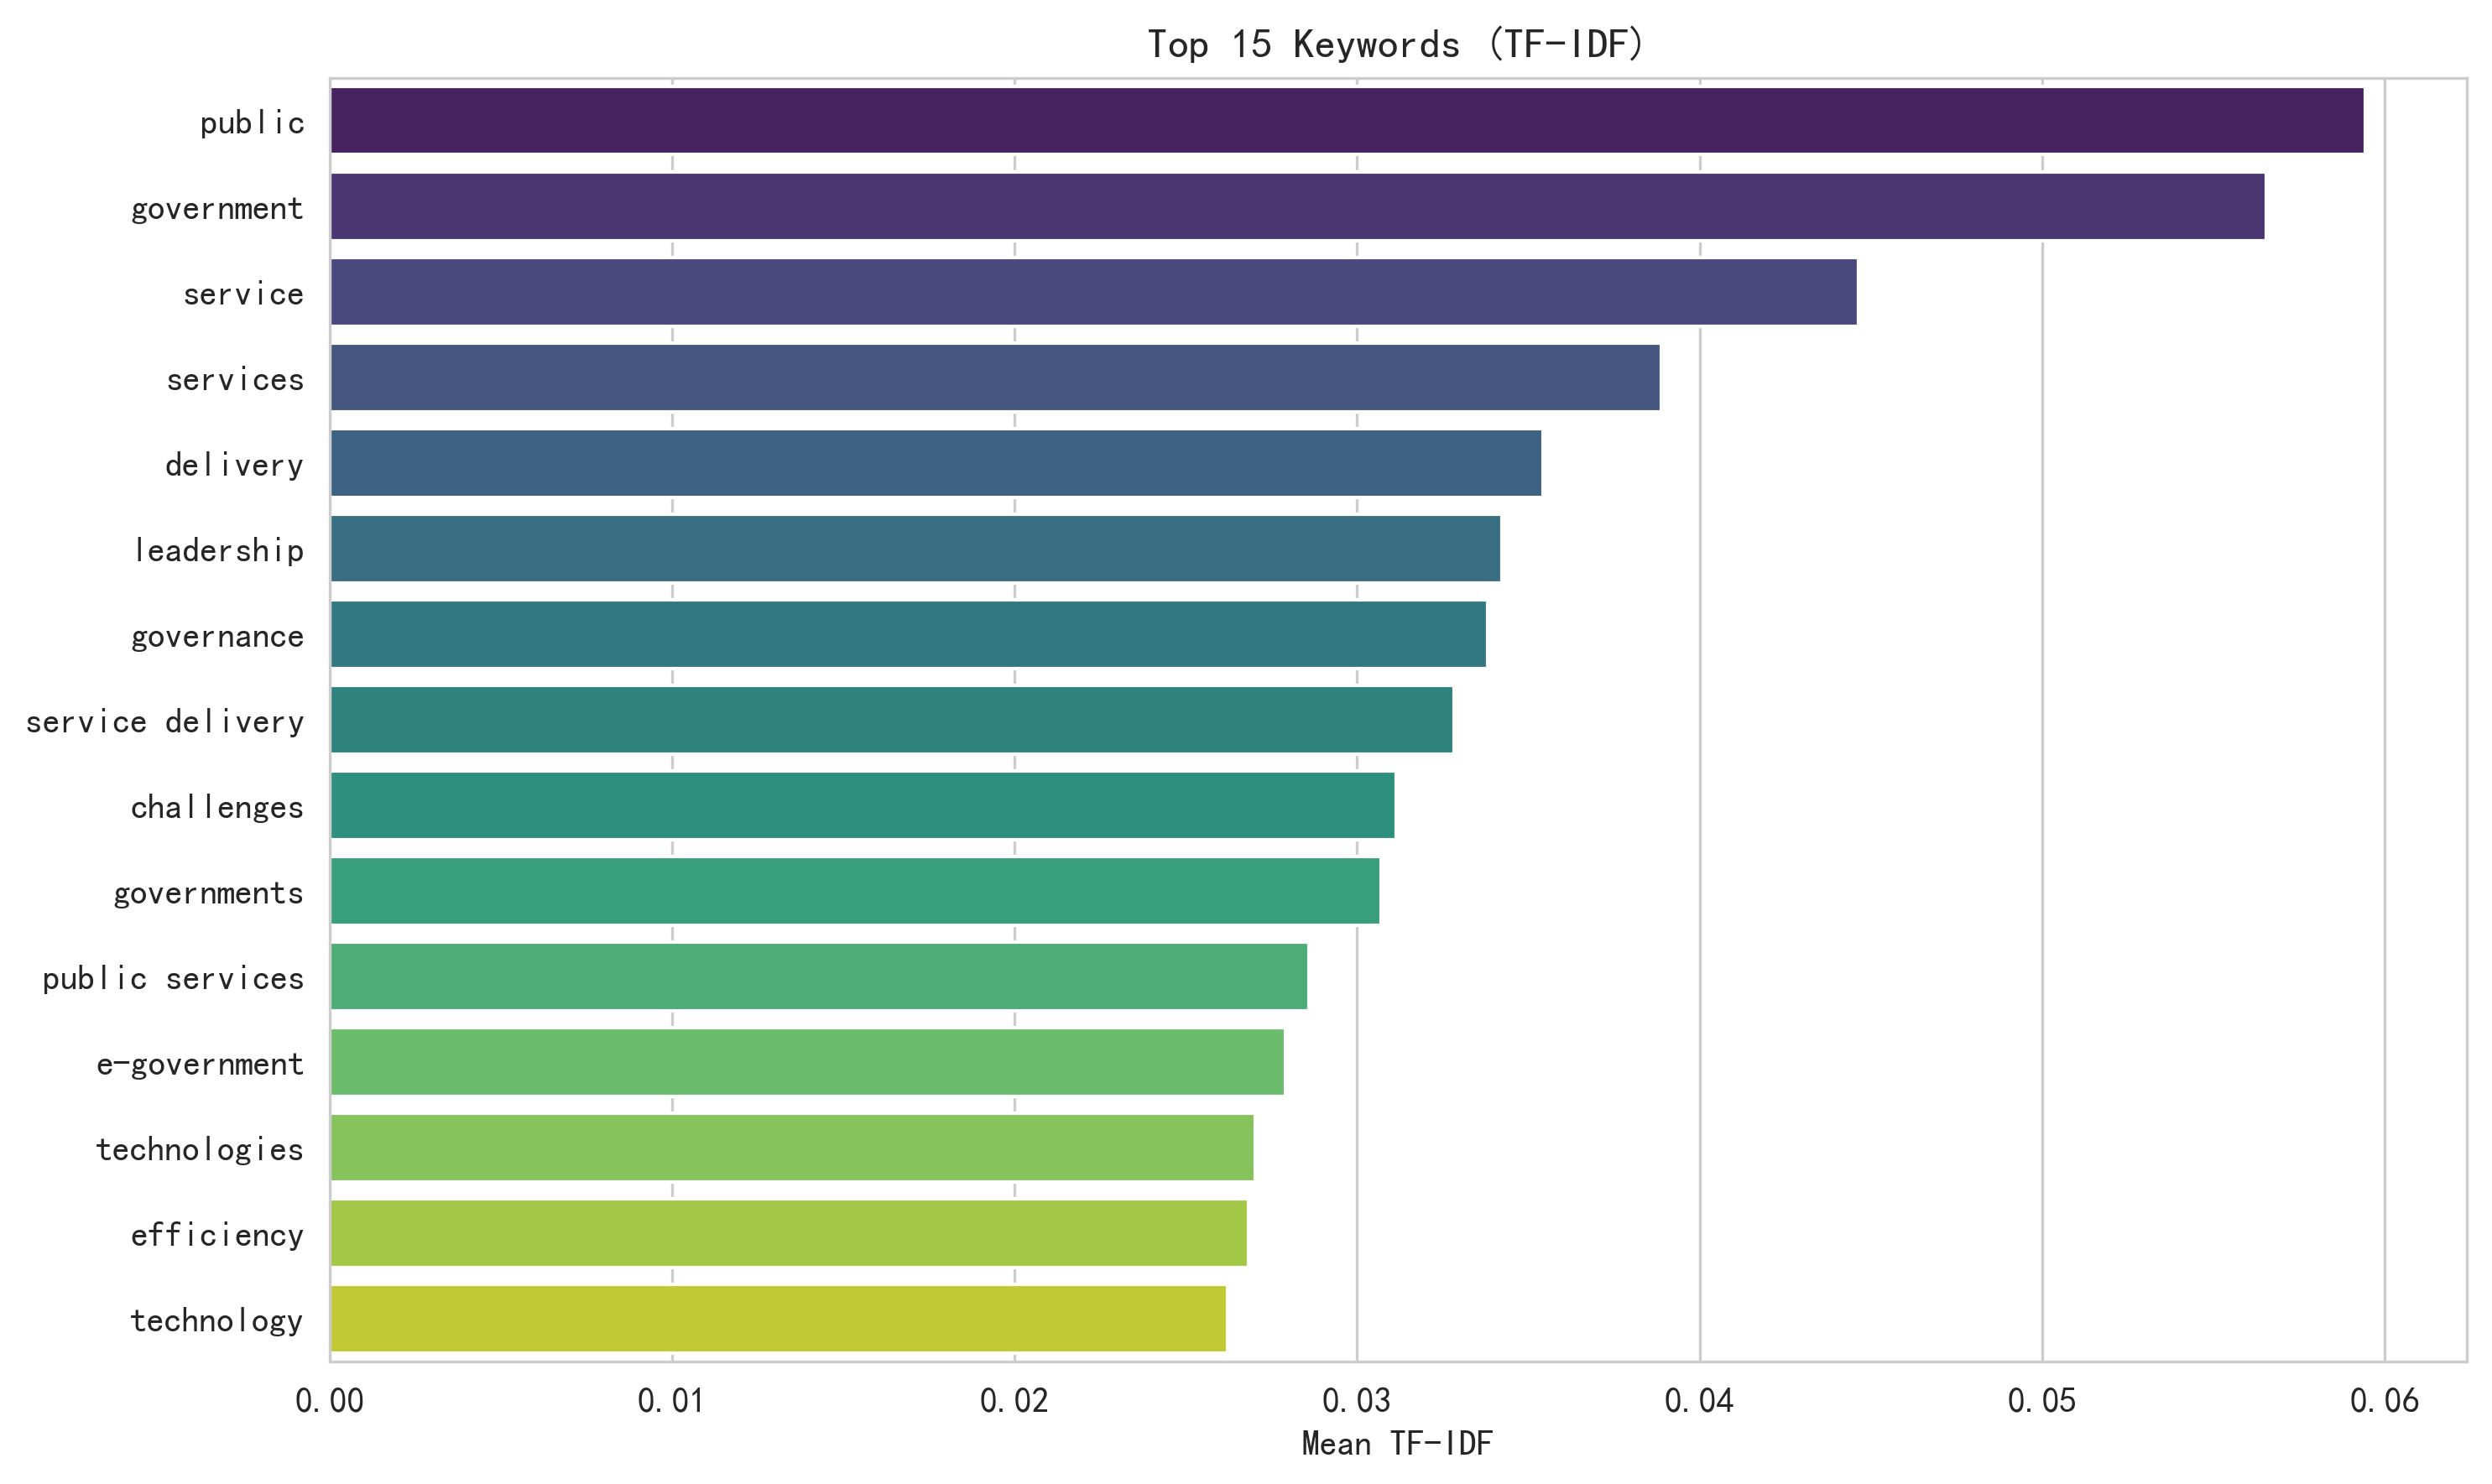


🧠 NMF：n_topics=10 (specificity-weighted boost)
✅ Seed boosting done: boosted_cols=64
----------------------------------------------------------------------
Topic 1: service delivery, delivery, public service, citizens, citizen, service, accessibility, access, public, public service delivery, satisfaction, services
Topic 2: transformational, leadership, transformational leadership, organizational, agility, adaptive, level, influence, vision, network, strategy, technological
Topic 3: making, processes, decision making, decision, discretion, automation, experience, administrative, quality, support, policy, solutions
Topic 4: role, role e-governance, including, inter-agency, collaboration, leadership, e-government, countries, examines, e-governance, capacity, service
Topic 5: administrative, organizational, collaboration, level, case, integration, rights, processes, institutional, information, inter-agency, boundaries
Topic 6: process, power, pandemic, public, state, vision, citizens, dec

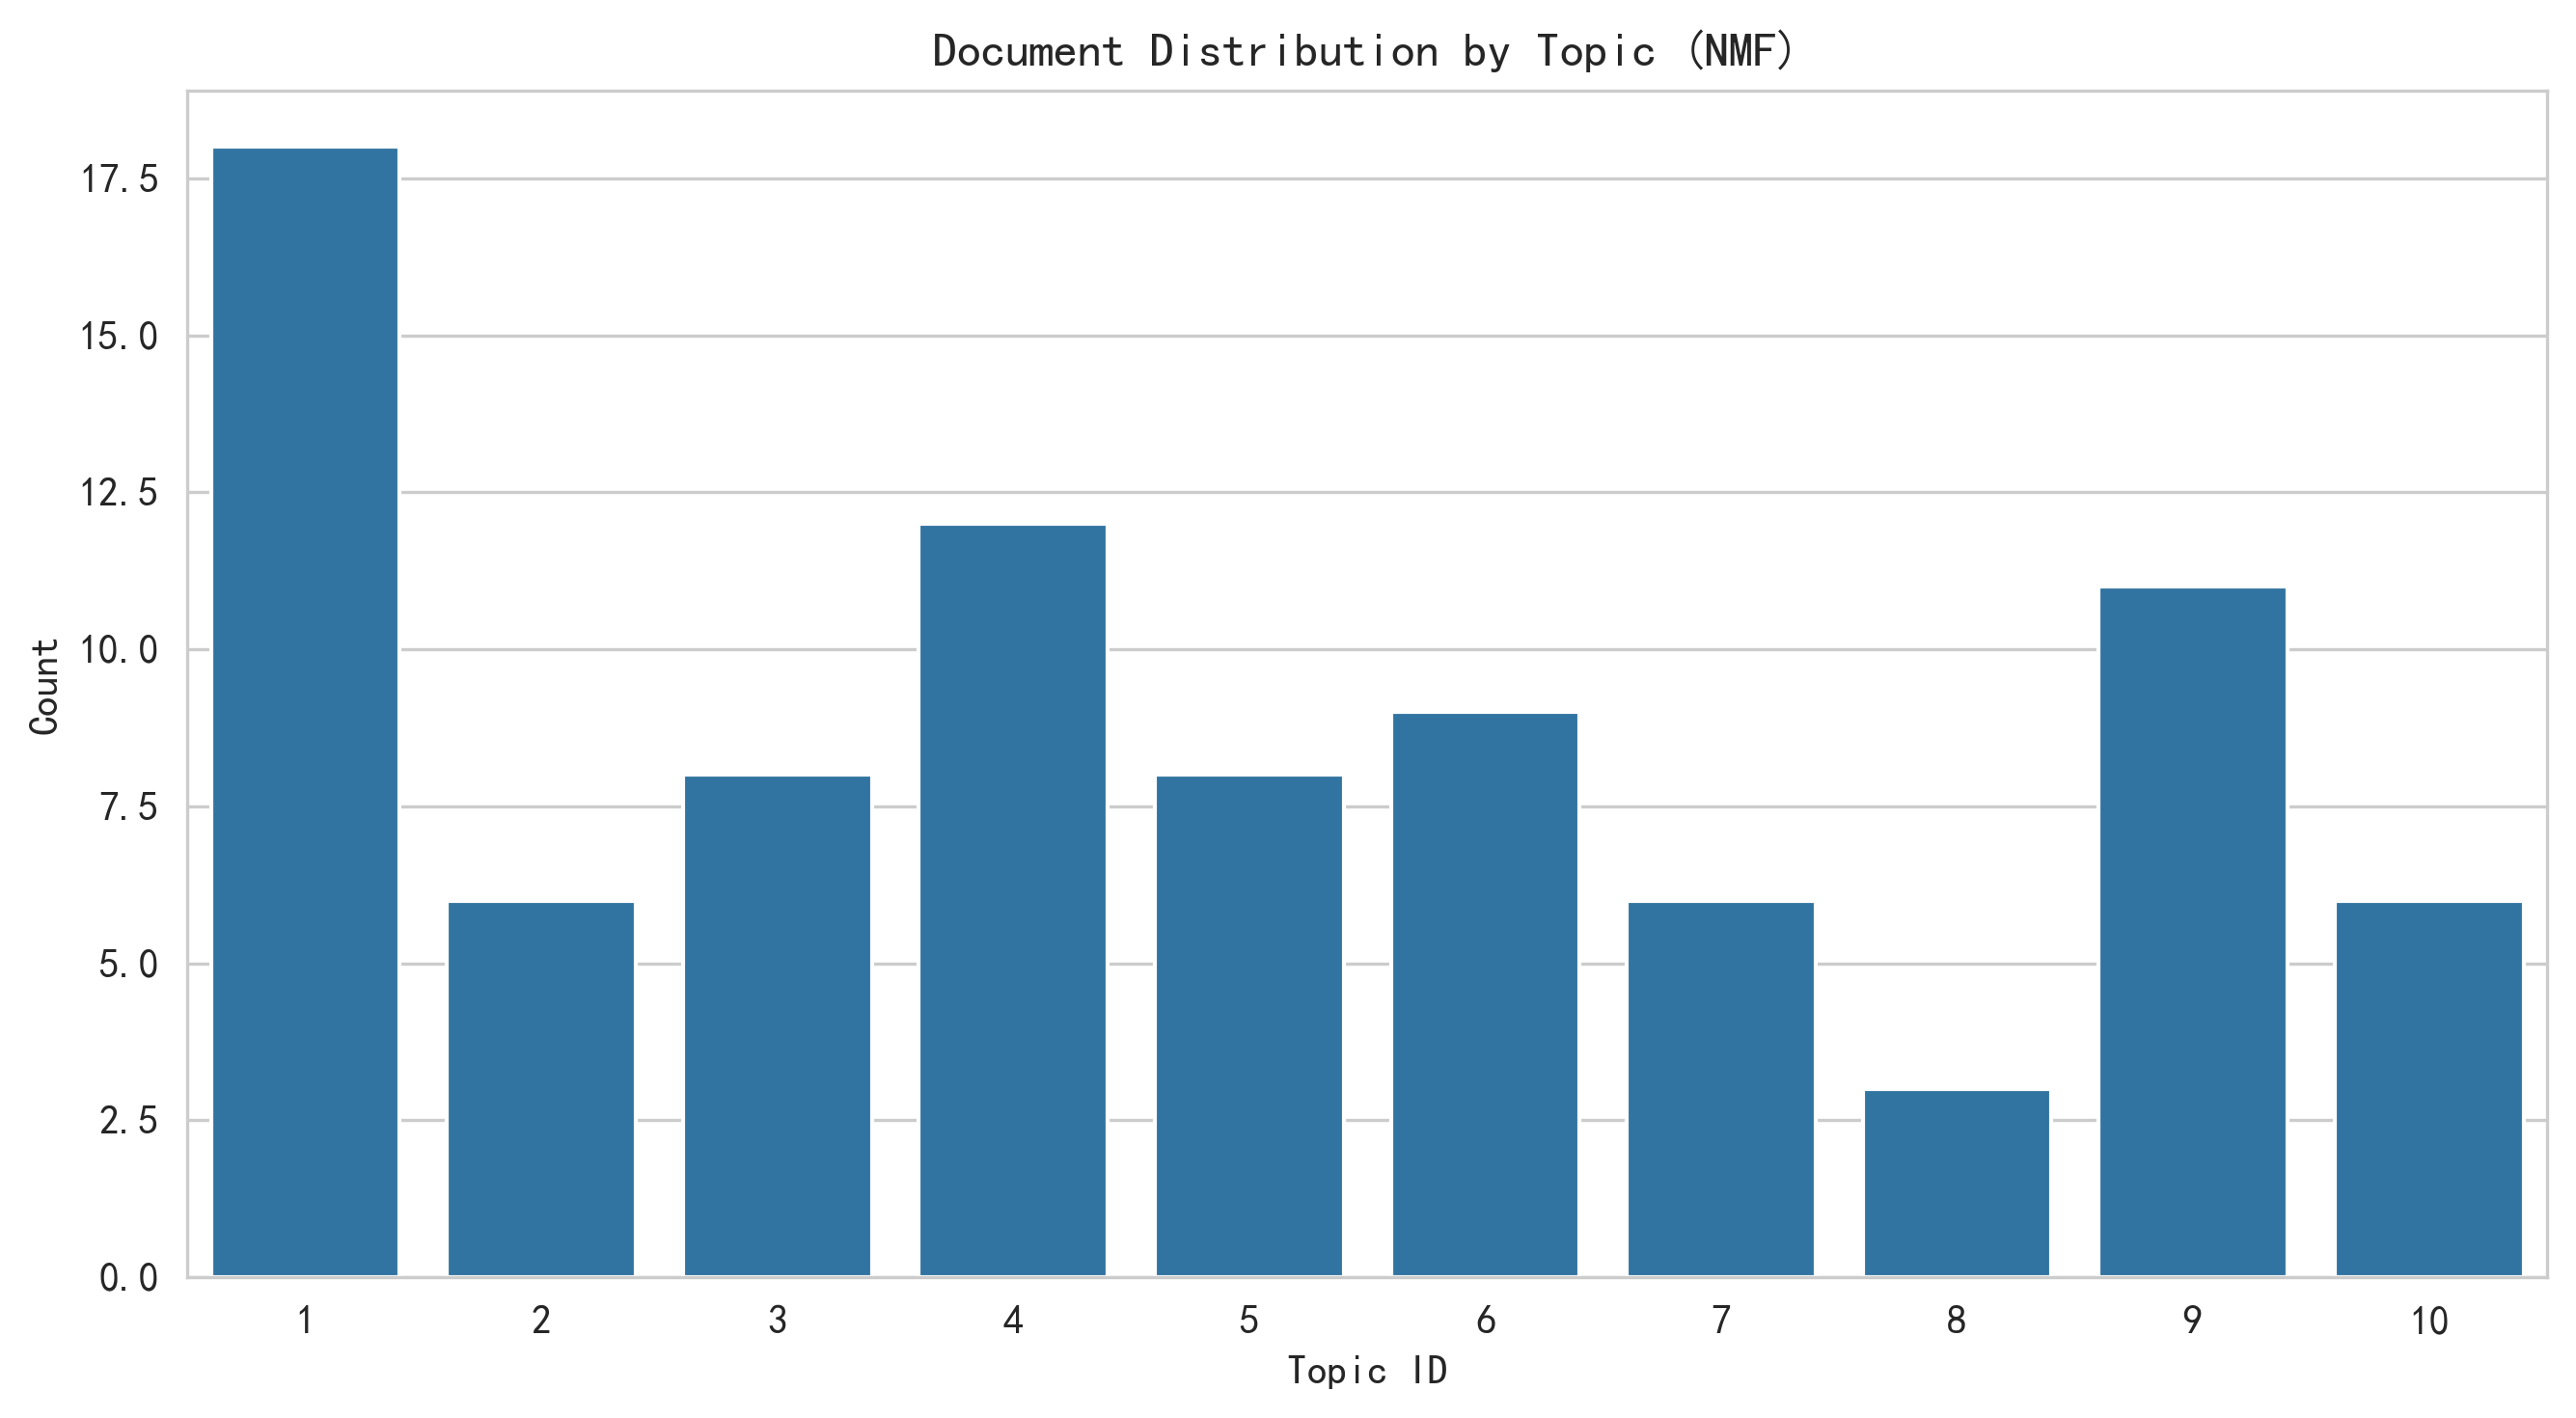


🧩 Topic -> Dimension（weighted overlap, ensure_all_dims=True）


,Topic_ID,Mapped_Dimension,WeightedOverlap,Top_terms_sample
2,3,Departmental responsibilities and administrati...,7.0,"making, processes, decision making, decision, ..."
9,10,Departmental responsibilities and administrati...,6.0,"mechanisms, roles, provision, service provisio..."
8,9,Government operating logic and processes,5.0,"accountability, business, leadership, organiza..."
7,8,Government operating logic and processes,4.0,"standard, departmental, rights, business, feat..."
4,5,Government organizational structure,7.5,"administrative, organizational, collaboration,..."
5,6,Government organizational structure,4.5,"process, power, pandemic, public, state, visio..."
1,2,Leadership,7.5,"transformational, leadership, transformational..."
6,7,Leadership,4.5,"bureaucracy, management, bureaucratic, organiz..."
3,4,Leadership,3.5,"role, role e-governance, including, inter-agen..."
0,1,Public service delivery,11.0,"service delivery, delivery, public service, ci..."



✅ Dimension counts (show zeros):
Public service delivery                                   18
Government organizational structure                       17
Government operating logic and processes                  14
Departmental responsibilities and administrative power    14
Leadership                                                24
Unmapped                                                   0
Name: Dimension, dtype: Int64

✅ #Topics mapped into each dimension:
Public service delivery                                   1
Government organizational structure                       2
Government operating logic and processes                  2
Departmental responsibilities and administrative power    2
Leadership                                                3
Unmapped                                                  0
dtype: int64


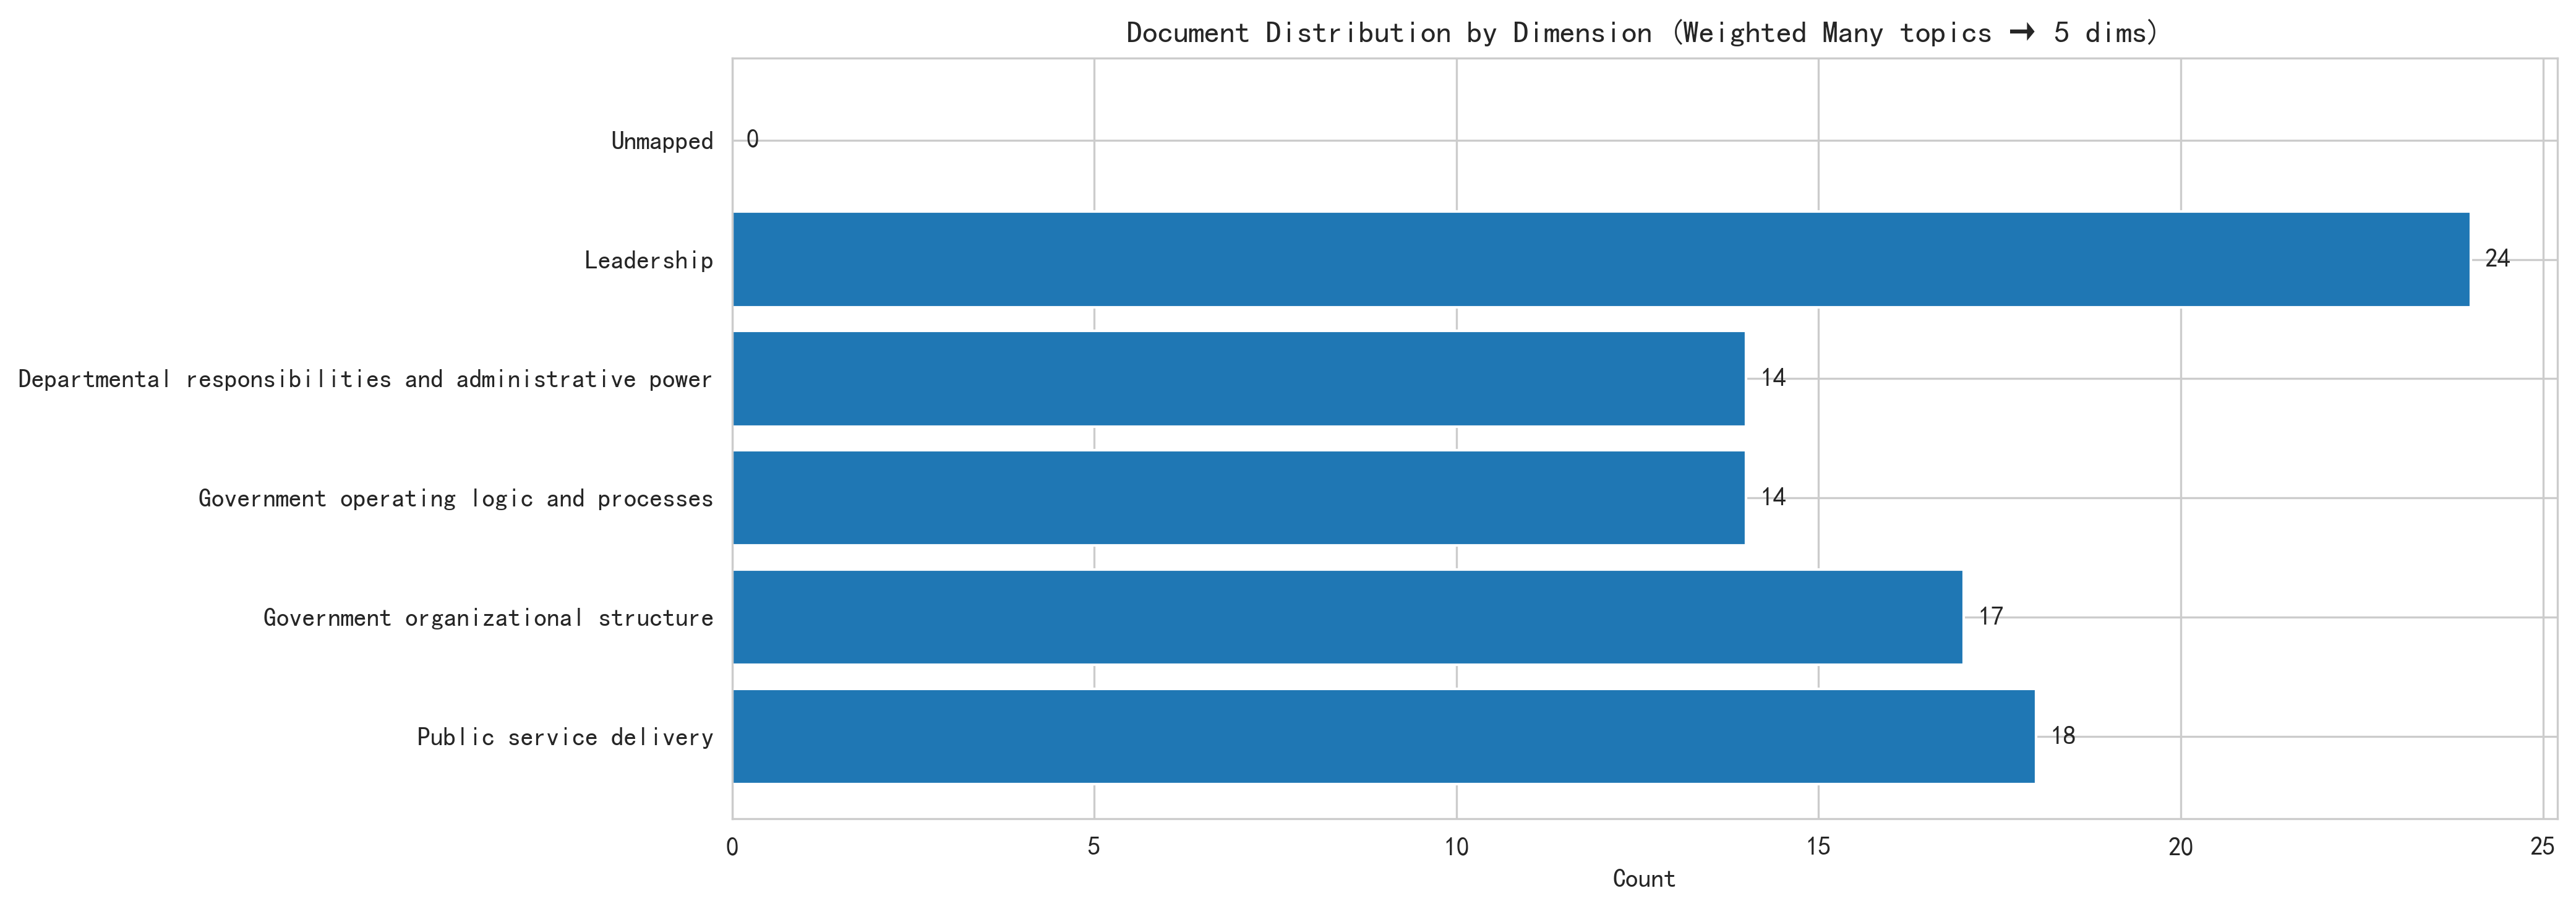


📝 Key sentence sample:


,title,Objective,Method,Result
0,{Digital government transformation: A case ill...,We investigate how digitalization of public se...,,
1,{Big Data-Driven Public Policy Decisions: Tran...,"Most studies focus on e-government, e-governan...","However, this article aims to explore the pote...","Most studies focus on e-government, e-governan..."
2,{Big Data Analytics: A Catalyst for Digital Tr...,,,The benefits of using BDA in e-Government are ...



💾 Saved: analysis_report.csv


In [10]:
# ===========================
# Public Management Literature Analyzer (BIB/RIS)
# - TF-IDF (1-3gram) + seed-features aligned with vectorizer analyzer
# - Specificity-weighted seeds: weight = 1 / (#dims sharing the token)
# - NMF topic modeling (n_topics can be > 5)
# - Many-to-one mapping with ensure_all_dims
# ===========================

import os
import re
import pandas as pd
import numpy as np
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import seaborn as sns

# ========== optional parsers + display ==========
try:
    import bibtexparser
    import rispy
    from IPython.display import display
except ImportError:
    print("!pip install bibtexparser rispy pandas scikit-learn matplotlib seaborn")
    def display(x): print(x)

sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# ========== stopwords (avoid putting 'public/government/governance' here) ==========
PM_STOP_WORDS = set(ENGLISH_STOP_WORDS)
PM_STOP_WORDS.update([
    "study","paper","article","research","review","result","results","finding","findings",
    "method","methods","methodology","approach","approaches","model","models","framework",
    "analysis","data","dataset","experiment","experimental","significant","demonstrate",
    "show","shown","present","provide","provides","discuss","discussion","conclusion",
    "based","use","used","using","new","novel","various","different",
    "digital","transformation","implementation","sector",
    "egovernment","electronic"
])
PM_STOP_WORDS = sorted(PM_STOP_WORDS)

# ========== 5-dimension seeds ==========
DIM_SEEDS = {
    "Public service delivery": [
        "service delivery","public service","service provision","citizen","citizens",
        "user experience","access","accessibility","convenience","satisfaction",
        "one stop","one-stop","portal","frontline","service quality"
    ],
    "Government organizational structure": [
        "organizational structure","restructuring","organization","hierarchy",
        "coordination","cross department","cross-department","interagency","inter-agency",
        "horizontal","integration","silo","network governance","collaboration"
    ],
    "Government operating logic and processes": [
        "workflow","workflows","workflow automation","approval workflow",
        "process","processes","service process","business process","business processes",
        "process automation","process standardization","standard operating procedures","sop",
        "procedure","procedures","case processing","case handling","transaction processing",
        "automation","automated workflow","streamlining","streamlined",
        "process reengineering","business process reengineering","bpr",
        "turnaround time","processing time","cycle time"
    ],
    "Departmental responsibilities and administrative power": [
        "administrative power","authority","administrative authority","jurisdiction","delegation",
        "allocation of authority","distribution of power",
        "discretion","administrative discretion","bureaucratic discretion",
        "accountability","accountability mechanisms",
        "roles and responsibilities","role clarity","mandate",
        "decision rights","decision making authority","administrative control","power asymmetry",
        "street level","level bureaucracy","street level bureaucracy",
        "division of labor","responsibility allocation","allocation of responsibilities",
        "departmental responsibilities","functional responsibilities"
    ],
    "Leadership": [
        "leadership","political support","top management","senior management",
        "strategic vision","commitment","champion","governance capacity",
        "transformational leadership","executive","mayor","party secretary"
    ]
}

def _to_str(x):
    if x is None:
        return ""
    if isinstance(x, list):
        return " ".join([str(i) for i in x if i is not None])
    return str(x)

def _clean_abstract(text: str) -> str:
    if not text:
        return ""
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text


class LiteratureAnalyzer:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = []
        self.df = None

        self.vectorizer = None
        self.feature_names = None
        self.tfidf_matrix = None

        self.nmf_model = None
        self.topic_values = None

        # seed-features aligned with vectorizer analyzer
        self.seed_features_by_dim = None

        # token specificity weights
        self.seed_token_dim_count = None
        self.seed_token_weight = None

        # topic->dimension map
        self.topic_to_dimension = None

    def load_data(self, min_abstract_len=30):
        if not self.filepath or not os.path.exists(self.filepath):
            print(f"❌ 找不到文件: {self.filepath}")
            return False

        ext = os.path.splitext(self.filepath)[1].lower()
        print(f"📂 读取: {self.filepath}")

        try:
            if ext == ".ris":
                with open(self.filepath, "r", encoding="utf-8", errors="ignore") as f:
                    entries = rispy.load(f)
                for e in entries:
                    title = _to_str(e.get("primary_title") or e.get("title") or "No Title")
                    abstract = _to_str(e.get("abstract") or e.get("notes") or "")
                    year = _to_str(e.get("year") or e.get("publication_year") or e.get("date") or "")
                    self.data.append({"title": title.strip(), "abstract": _clean_abstract(abstract), "year": year.strip()})

            elif ext == ".bib":
                with open(self.filepath, "r", encoding="utf-8", errors="ignore") as f:
                    bib_database = bibtexparser.load(f)
                for e in bib_database.entries:
                    title = _to_str(e.get("title", "No Title"))
                    abstract = _to_str(e.get("abstract", ""))
                    year = _to_str(e.get("year", ""))
                    self.data.append({"title": title.strip(), "abstract": _clean_abstract(abstract), "year": year.strip()})
            else:
                print("❌ 仅支持 .ris / .bib")
                return False

            self.df = pd.DataFrame(self.data)
            self.df["abstract"] = self.df["abstract"].fillna("").astype(str)
            self.df = self.df[self.df["abstract"].str.len() >= min_abstract_len].copy()

            print(f"✅ 有效文献: {len(self.df)}（摘要≥{min_abstract_len}）")
            display(self.df[["title", "year"]].head(5))
            return True
        except Exception as e:
            print(f"❌ 读取失败: {e}")
            return False

    def build_tfidf(self, max_features=8000, max_df=0.98, min_df=2, ngram_range=(1, 3)):
        print("\n🔧 构建 TF-IDF（1-3gram）...")
        self.vectorizer = TfidfVectorizer(
            stop_words=PM_STOP_WORDS,
            ngram_range=ngram_range,
            max_features=max_features,
            max_df=max_df,
            min_df=min_df,
            sublinear_tf=True,
            token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z0-9\-]+\b"
        )
        self.tfidf_matrix = self.vectorizer.fit_transform(self.df["abstract"])
        self.feature_names = self.vectorizer.get_feature_names_out()
        print(f"✅ TF-IDF 维度: {self.tfidf_matrix.shape}")

        self._prepare_seed_features_and_weights()

    def _prepare_seed_features_and_weights(self):
        analyzer = self.vectorizer.build_analyzer()
        vocab = set(self.feature_names)

        # seed-features per dimension
        self.seed_features_by_dim = {}
        for dim, seed_phrases in DIM_SEEDS.items():
            feats = set()
            for phrase in seed_phrases:
                
                SEED_TOKEN_BLACKLIST = {"public", "service"}  # 关键：防止 service 维度吞噬其他维度
                
                for tok in analyzer(phrase):
                    if tok in SEED_TOKEN_BLACKLIST:
                        continue
                    if tok in vocab:
                        feats.add(tok)

            self.seed_features_by_dim[dim] = feats

        # token -> how many dims contain it
        counts = {}
        for dim, feats in self.seed_features_by_dim.items():
            for f in feats:
                counts[f] = counts.get(f, 0) + 1
        self.seed_token_dim_count = counts
        self.seed_token_weight = {f: 1.0 / counts[f] for f in counts}

        print("\n🧪 Seed-features 命中诊断（hits + sample）")
        for dim in DIM_SEEDS.keys():
            hits = sorted(list(self.seed_features_by_dim[dim]))
            print(f"  - {dim}: hits={len(hits)} | {hits[:12]}")

        # 额外诊断：哪些 seed-features 被多维共享（最容易导致“流程维度被抢走”）
        shared = sorted([(f, c) for f, c in counts.items() if c >= 2], key=lambda x: (-x[1], x[0]))
        if shared:
            print("\n🧪 Shared seed-features (dim_count>=2) top15:")
            print(shared[:15])

    def analyze_keywords(self, top_n=15, plot=True):
        if self.tfidf_matrix is None:
            print("⚠️ 先 build_tfidf()")
            return []

        mean_tfidf = np.asarray(self.tfidf_matrix.mean(axis=0)).ravel()
        top_idx = mean_tfidf.argsort()[-top_n:][::-1]
        keywords = [self.feature_names[i] for i in top_idx]
        scores = [mean_tfidf[i] for i in top_idx]

        if plot:
            plt.figure(figsize=(10, 6), dpi=300)
            sns.barplot(x=scores, y=keywords, hue=keywords, palette="viridis", legend=False)
            plt.title(f"Top {top_n} Keywords (TF-IDF)")
            plt.xlabel("Mean TF-IDF")
            plt.ylabel("")
            plt.tight_layout()
            plt.show()

        return keywords

    def _boost_seed_features(self, boost_dict):
        """
        关键修正：同一 feature 可能出现在多个维度 seeds 中。
        - 不重复乘（避免被多次放大导致失真）
        - 对每个 feature 只应用一个 scale：取 max(dim_boost * specificity_weight)
        """
        if self.seed_features_by_dim is None:
            print("⚠️ seed_features_by_dim 为空：先 build_tfidf()")
            return 0

        term_to_idx = {t: i for i, t in enumerate(self.feature_names)}
        col_scale = {}  # col_idx -> scale

        for dim, feats in self.seed_features_by_dim.items():
            b = float(boost_dict.get(dim, 1.0))
            if b <= 1.0:
                continue
            for f in feats:
                j = term_to_idx.get(f, None)
                if j is None:
                    continue
                w = float(self.seed_token_weight.get(f, 1.0))  # specificity
                s = b * w
                # one column, one scaling: take max
                if j not in col_scale or s > col_scale[j]:
                    col_scale[j] = s

        if not col_scale:
            print("⚠️ 没有可 boost 的 seed-features 列")
            return 0

        mat = self.tfidf_matrix.tocsc(copy=True)
        for j, s in col_scale.items():
            if s > 1.0:
                mat[:, j] = mat[:, j].multiply(s)
        self.tfidf_matrix = mat.tocsr()

        print(f"✅ Seed boosting done: boosted_cols={len(col_scale)}")
        return len(col_scale)

    def extract_topics_guided(self, n_topics=12, seed_boost=None, top_terms=12, plot=True):
        if self.tfidf_matrix is None:
            print("⚠️ 先 build_tfidf()")
            return

        if seed_boost is None:
            seed_boost = {d: 2.5 for d in DIM_SEEDS.keys()}

        print(f"\n🧠 NMF：n_topics={n_topics} (specificity-weighted boost)")
        self._boost_seed_features(seed_boost)

        self.nmf_model = NMF(
            n_components=n_topics,
            random_state=42,
            init="nndsvda",
            max_iter=1500
        )
        self.topic_values = self.nmf_model.fit_transform(self.tfidf_matrix)
        self.df["Topic_ID"] = (self.topic_values.argmax(axis=1) + 1).astype(int)

        print("-" * 70)
        for k, comp in enumerate(self.nmf_model.components_, start=1):
            top_idx = comp.argsort()[::-1][:top_terms]
            words = [self.feature_names[i] for i in top_idx]
            print(f"Topic {k}: {', '.join(words)}")
        print("-" * 70)

        if plot:
            plt.figure(figsize=(9, 5), dpi=300)
            sns.countplot(x="Topic_ID", data=self.df, color=sns.color_palette()[0])
            plt.title("Document Distribution by Topic (NMF)")
            plt.xlabel("Topic ID")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()

    def map_topics_to_dimensions_many(self, top_k=35, min_score=1.0, ensure_all_dims=True, plot=True):
        """
        关键修正：mapping score 用“加权 overlap”，不是简单计数：
        score(topic, dim) = sum( specificity_weight(token) for token in intersection )
        """
        if self.nmf_model is None:
            print("⚠️ 先 extract_topics_guided()")
            return None
        if self.seed_features_by_dim is None:
            print("⚠️ 先 build_tfidf()")
            return None

        dims = list(DIM_SEEDS.keys())
        dim_seed_sets = {d: set([x.lower() for x in self.seed_features_by_dim.get(d, set())]) for d in dims}

        # topic -> top terms
        topic_top_terms = {}
        for topic_idx, comp in enumerate(self.nmf_model.components_, start=1):
            top_idx = comp.argsort()[::-1][:top_k]
            topic_top_terms[topic_idx] = [self.feature_names[i] for i in top_idx]

        topics = list(topic_top_terms.keys())

        # weighted score matrix
        score = np.zeros((len(topics), len(dims)), dtype=float)
        for i, t in enumerate(topics):
            terms_lower = set([x.lower() for x in topic_top_terms[t]])
            for j, d in enumerate(dims):
                inter = terms_lower & dim_seed_sets[d]
                score[i, j] = sum(float(self.seed_token_weight.get(tok, 1.0)) for tok in inter)

        # baseline many-to-one
        base_map = {}
        for i, t in enumerate(topics):
            best_j = int(score[i].argmax())
            best_dim = dims[best_j]
            best_score = float(score[i, best_j])
            base_map[t] = best_dim if best_score >= float(min_score) else "Unmapped"

        mapping = dict(base_map)

        # ensure coverage: anchor topics for each dim (greedy on weighted score)
        if ensure_all_dims:
            impossible = [dims[j] for j in range(len(dims)) if score[:, j].max() < float(min_score)]
            if impossible:
                print(f"⚠️ 无法覆盖这些维度（所有 topic 的加权得分都 < {min_score}）：{impossible}")
            else:
                pairs = []
                for i, t in enumerate(topics):
                    for j, d in enumerate(dims):
                        pairs.append((float(score[i, j]), t, d))
                pairs.sort(reverse=True, key=lambda x: x[0])

                used_topics, used_dims = set(), set()
                for s, t, d in pairs:
                    if s < float(min_score):
                        break
                    if t in used_topics or d in used_dims:
                        continue
                    mapping[t] = d
                    used_topics.add(t)
                    used_dims.add(d)
                    if len(used_dims) == len(dims):
                        break

        # output mapping table
        rows = []
        for i, t in enumerate(topics):
            mapped = mapping[t]
            best_s = 0.0
            if mapped in dims:
                j = dims.index(mapped)
                best_s = float(score[i, j])
            rows.append({
                "Topic_ID": t,
                "Mapped_Dimension": mapped,
                "WeightedOverlap": round(best_s, 3),
                "Top_terms_sample": ", ".join(topic_top_terms[t][:12])
            })

        map_df = pd.DataFrame(rows).sort_values(["Mapped_Dimension", "WeightedOverlap"], ascending=[True, False])
        print(f"\n🧩 Topic -> Dimension（weighted overlap, ensure_all_dims={ensure_all_dims}）")
        display(map_df)

        self.df["Topic_ID"] = self.df["Topic_ID"].astype(int)
        self.df["Dimension"] = self.df["Topic_ID"].map(mapping).astype("string").str.strip()

        show_dims = dims + ["Unmapped"]
        counts = self.df["Dimension"].value_counts(dropna=False).reindex(show_dims, fill_value=0)
        print("\n✅ Dimension counts (show zeros):")
        print(counts)

        topic_dim_counts = pd.Series(mapping).value_counts().reindex(show_dims, fill_value=0)
        print("\n✅ #Topics mapped into each dimension:")
        print(topic_dim_counts)

        if plot:
            plt.figure(figsize=(14, 5), dpi=300)
            plt.barh(counts.index, counts.values)
            plt.title("Document Distribution by Dimension (Weighted Many topics → 5 dims)")
            plt.xlabel("Count")
            plt.gcf().subplots_adjust(left=0.42)
            for ii, v in enumerate(counts.values):
                plt.text(v + 0.2, ii, str(v), va="center")
            plt.tight_layout()
            plt.show()

        self.topic_to_dimension = mapping
        return mapping, map_df

    def extract_key_sentences(self, sample_n=3):
        if self.df is None or self.df.empty:
            print("⚠️ 没有数据")
            return

        regex = {
            "Objective": re.compile(
                r"\b(aims?\s+to|objective\s+is\s+to|purpose\s+is\s+to|we\s+investigate|this\s+paper\s+examines|focus(?:es)?\s+on)\b",
                re.IGNORECASE
            ),
            "Method": re.compile(
                r"\b(we\s+propose|we\s+develop|we\s+use|we\s+utili[sz]e|method|approach|framework|case\s+study|interviews?|coding|qualitative|quantitative|survey|regression|fsqca|experiment)\b",
                re.IGNORECASE
            ),
            "Result": re.compile(
                r"\b(we\s+find|results?\s+show|we\s+show|we\s+demonstrate|our\s+findings\s+indicate|this\s+study\s+reveals|improv(?:e|es|ed)|outperform(?:s|ed)?)\b",
                re.IGNORECASE
            ),
        }

        rows = []
        for text in self.df["abstract"].astype(str).tolist():
            obj = met = res = ""
            sents = re.split(r"(?<=[\.\?\!])\s+", text)
            for s in sents:
                if not obj and regex["Objective"].search(s):
                    obj = s.strip()
                if not met and regex["Method"].search(s):
                    met = s.strip()
                if not res and regex["Result"].search(s):
                    res = s.strip()
            rows.append({"Objective": obj, "Method": met, "Result": res})

        struct_df = pd.DataFrame(rows)
        for c in ["Objective", "Method", "Result"]:
            if c in self.df.columns:
                self.df.drop(columns=[c], inplace=True)
        self.df = pd.concat([self.df, struct_df], axis=1)

        print("\n📝 Key sentence sample:")
        display(self.df[["title", "Objective", "Method", "Result"]].head(sample_n))

    def save_results(self, output_file="analysis_report.csv"):
        if self.df is None or self.df.empty:
            print("⚠️ 无结果可保存")
            return
        self.df.to_csv(output_file, index=False, encoding="utf-8-sig")
        print(f"\n💾 Saved: {output_file}")


# ===========================
# RUN
# ===========================
target_filename = "ktss.bib"  # 改成你的路径
N_TOPICS = 10

SEED_BOOST = {
    "Public service delivery": 3.0,
    "Government organizational structure": 3.0,
    "Government operating logic and processes": 4.0,  # 流程维度适当更强
    "Departmental responsibilities and administrative power": 4.5,
    "Leadership": 2.8
}

analyzer = LiteratureAnalyzer(target_filename)

if analyzer.load_data(min_abstract_len=30):
    analyzer.build_tfidf(
        max_features=8000,
        max_df=0.98,
        min_df=2,
        ngram_range=(1, 3)
    )

    analyzer.analyze_keywords(top_n=15, plot=True)

    analyzer.extract_topics_guided(
        n_topics=N_TOPICS,
        seed_boost=SEED_BOOST,
        top_terms=12,
        plot=True
    )

    # 注意：min_score 是“加权 overlap”的阈值（不是计数），一般 0.8~1.2 合理
    analyzer.map_topics_to_dimensions_many(
        top_k=60,
        min_score=1.0,
        ensure_all_dims=True,
        plot=True
    )

    analyzer.extract_key_sentences(sample_n=3)
    analyzer.save_results("analysis_report.csv")
